In [1]:
import json
import pywt
import random
import numpy as np
import matplotlib.pyplot as plt

from conf import LumosConf
from feature_select import *
from collections import defaultdict
from data_loader_ordinal import DataLoaderOrdinal

In [2]:
conf = LumosConf()
data_dump_pth = conf.get('dataset', 'dump_pth_ordinal_with_truc_v1')
data_loader = DataLoaderOrdinal(dump_pth=data_dump_pth)
data_loader.load_data_by_interval(interval=1)
fontsize=14

In [3]:
data = data_loader.get_data()

In [5]:
data['1']['hive_aggregationAVG']['small'][0]

{
    "inst_type": "s6.2xlarge.2",
    "metrics.shape": [
        46,
        62
    ],
    "ts": [
        0.7142857142857143,
        0.9166666666666666
    ],
    "jct": 45.0,
    "rank": -1
}

In [6]:
scales = ['tiny', 'small', 'large', 'huge']
hp_metrics = [data['1']['hadoop_pagerank'][scale][0].metrics for scale in scales]

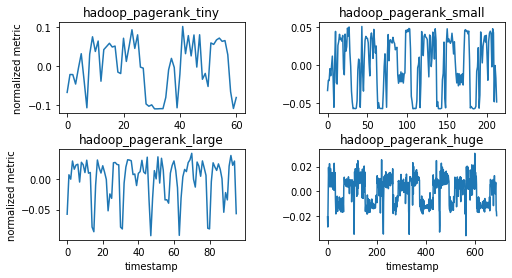

In [7]:
cnt = 1
plt.figure(figsize=(8,4))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for scale, metrics in zip(scales, hp_metrics):
    plt.subplot(2, 2, cnt)
    if cnt % 2:
        plt.ylabel('normalized metric')
    if cnt > 2:
        plt.xlabel('timestamp')
    plt.title('hadoop_pagerank_%s' % scale)
    plt.plot(metrics[:, 0])
    cnt += 1

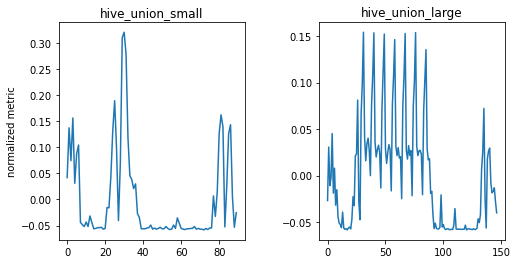

In [8]:
scales = ['small', 'large']
wl_name = 'hive_union'
hive_metrics = [data['1'][wl_name][scale][0].metrics for scale in scales]

cnt = 1
plt.figure(figsize=(8,4))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for scale, metrics in zip(scales, hive_metrics):
    plt.subplot(1, 2, cnt)
    if cnt % 2:
        plt.ylabel('normalized metric')
    if cnt > 2:
        plt.xlabel('timestamp')
    plt.title('%s_%s' % (wl_name, scale))
    plt.plot(metrics[:, 0])
    cnt += 1

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [5]:
train_data, test_data = data_loader.get_train_test_data_external(test_wl='hadoop_join', train_scale='small', ordinal=True)

In [6]:
regressor = RandomForestRegressor(max_depth=3)
train_X = train_data['1']['g6.xlarge']['X']
train_Y = train_data['1']['g6.xlarge']['Y']
test_X = test_data['1']['g6.xlarge']['large']['X']
test_Y = test_data['1']['g6.xlarge']['large']['Y']

In [7]:
regressor.fit(train_X, train_Y)

RandomForestRegressor(max_depth=3)

In [8]:
test_Y_bar = regressor.predict(test_X)
test_rank_bar = np.argsort(test_Y_bar)

In [9]:
test_rank_bar

array([ 1,  2, 18,  4, 17,  6,  7,  8, 16, 15, 32,  0, 22, 10,  9,  5,  3,
       11, 20, 21, 40, 46, 14, 26, 12, 44, 28, 38, 27, 23, 24, 13, 30, 53,
       29, 31, 25, 36, 52, 51, 50, 48, 19, 41, 42, 39, 34, 33, 43, 45, 47,
       37, 49, 35, 54])

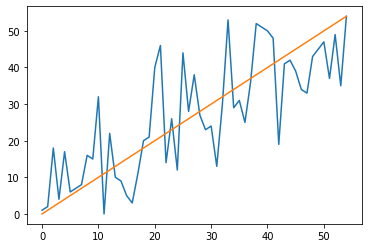

In [10]:
plt.plot(test_rank_bar)
plt.plot(np.arange(55))

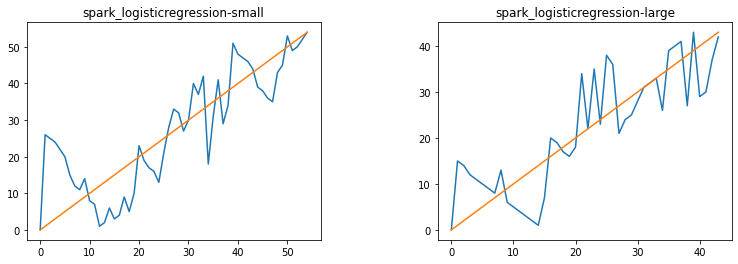

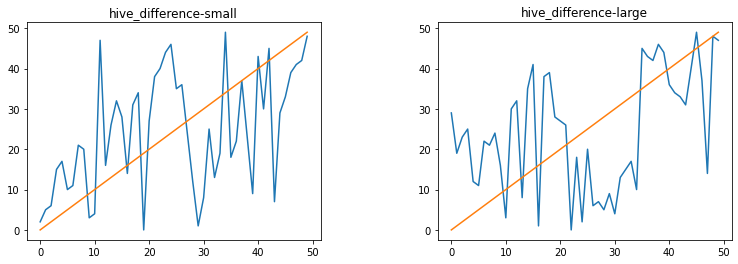

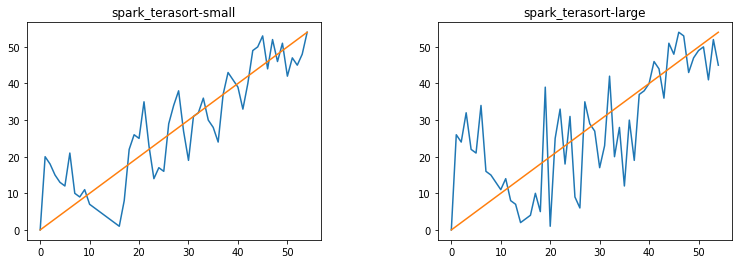

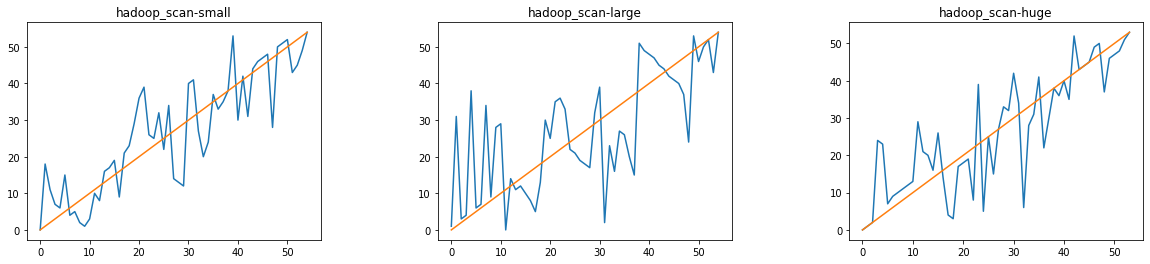

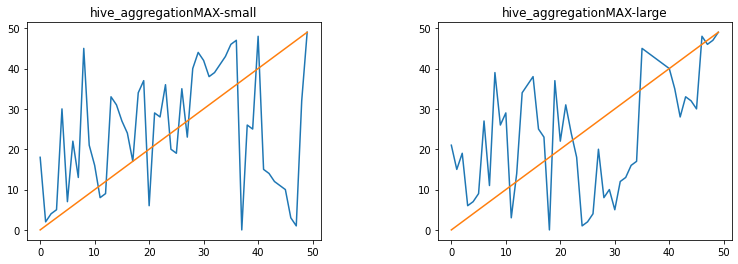

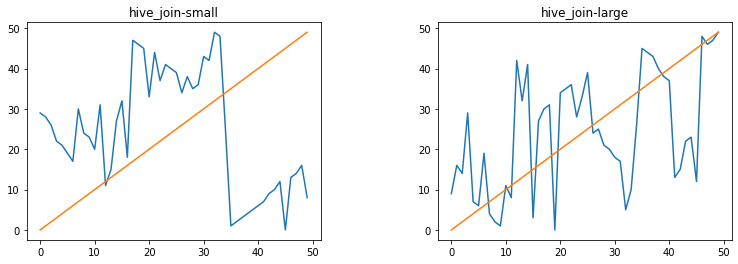

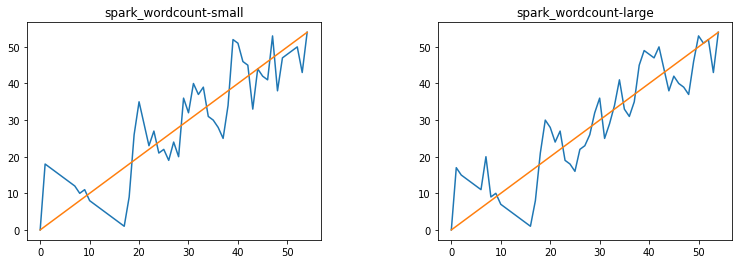

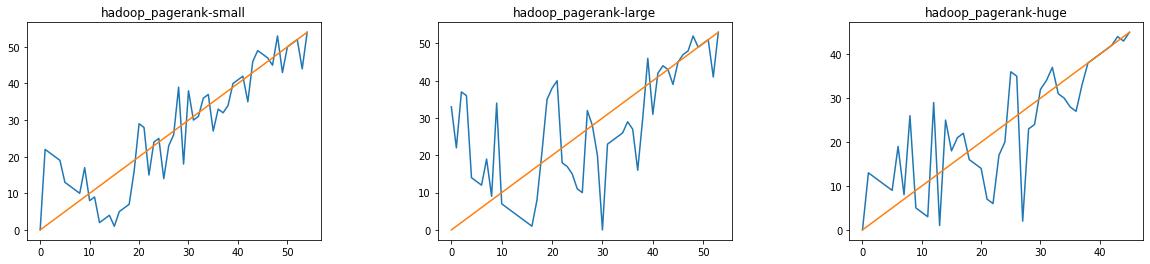

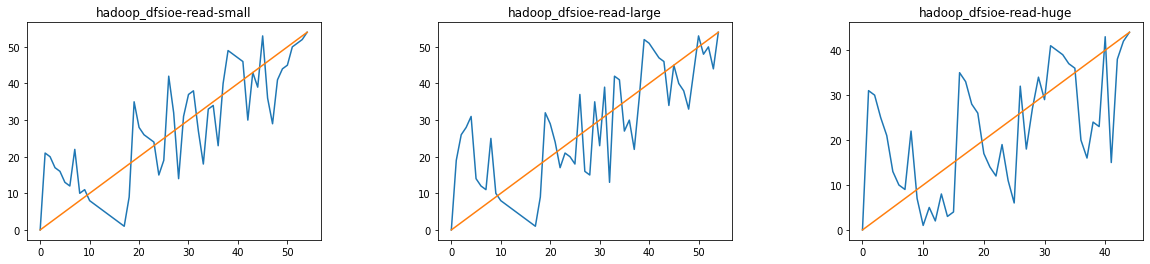

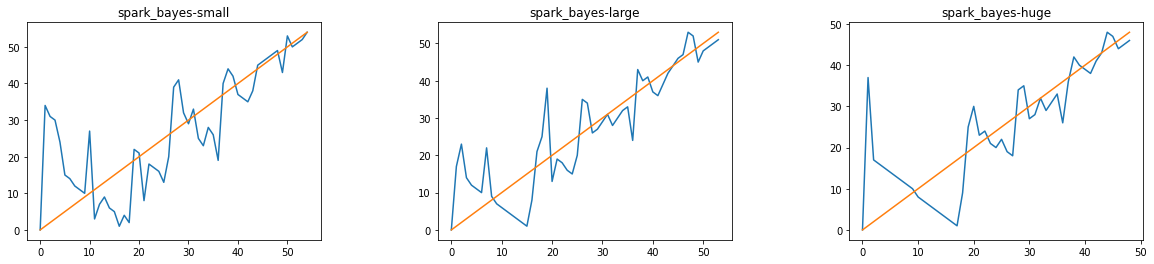

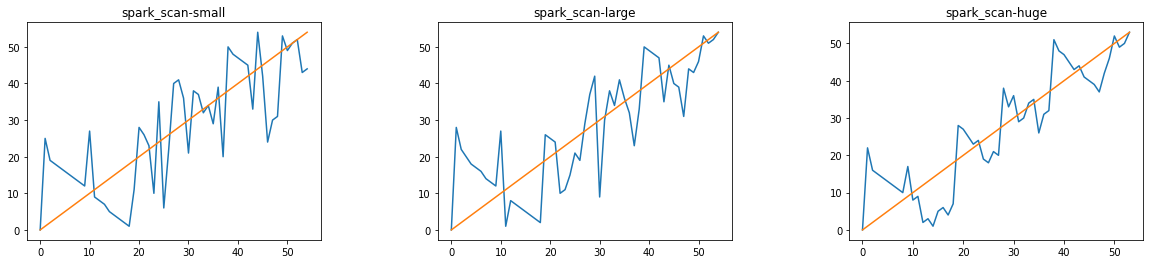

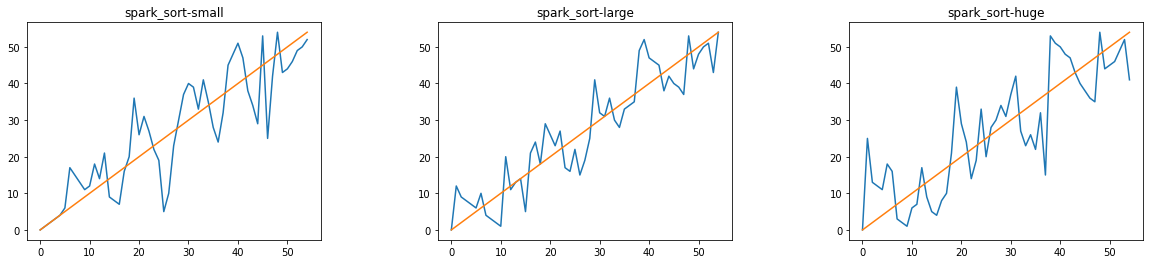

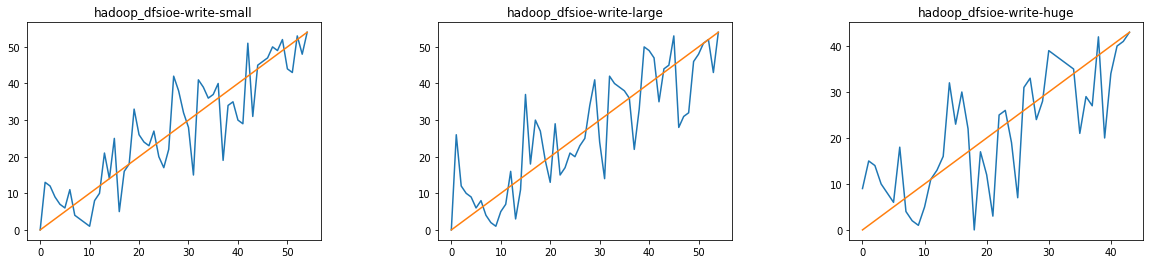

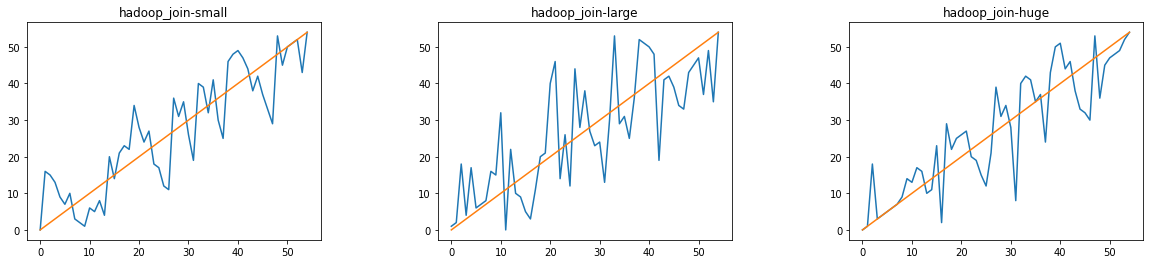

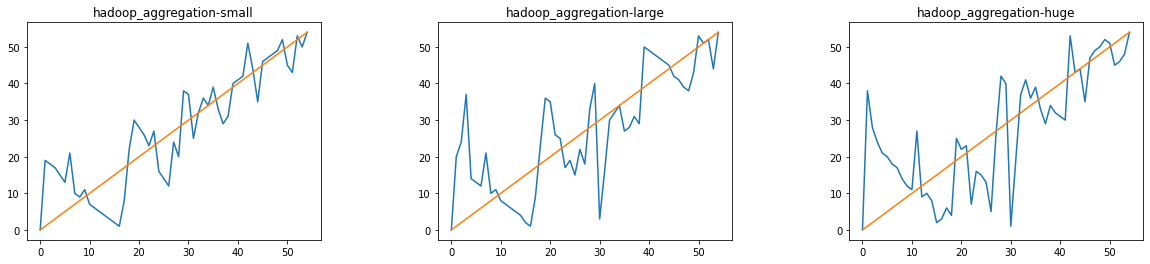

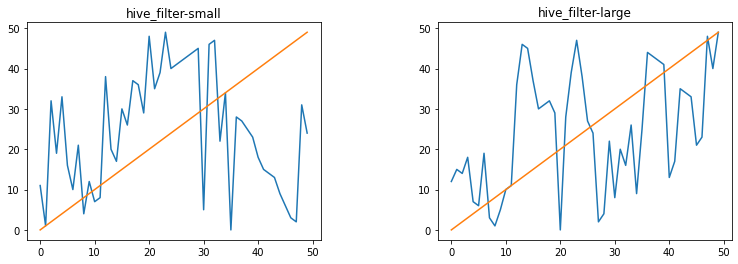

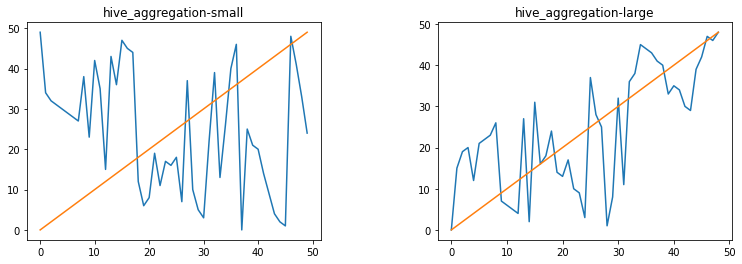

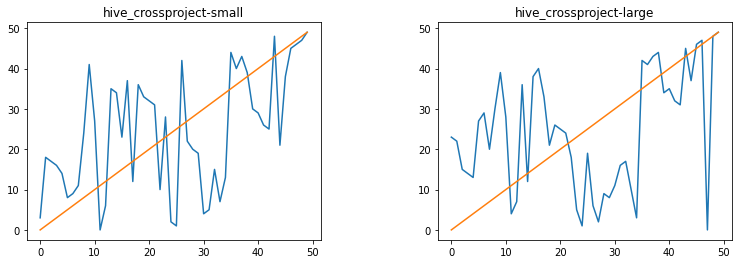

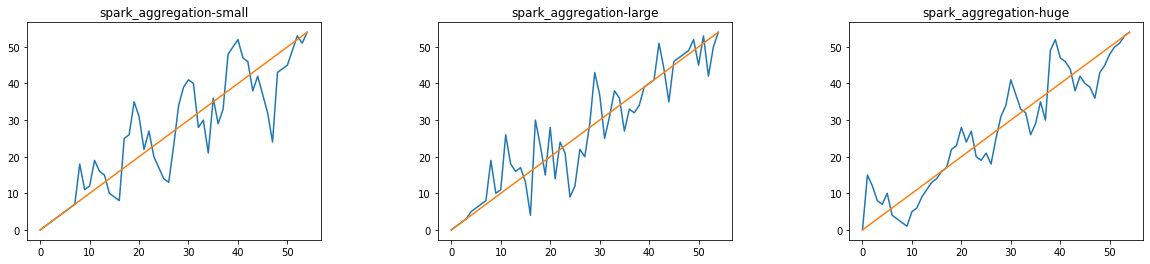

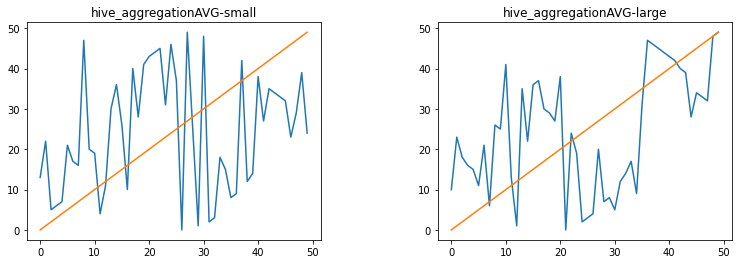

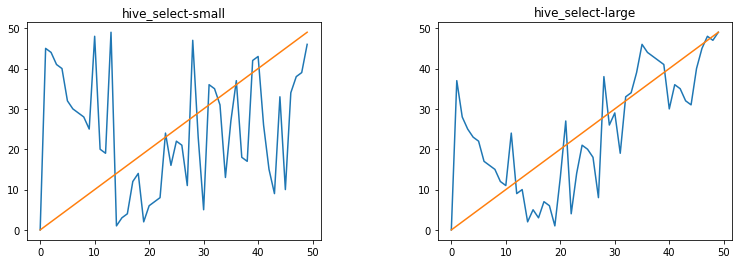

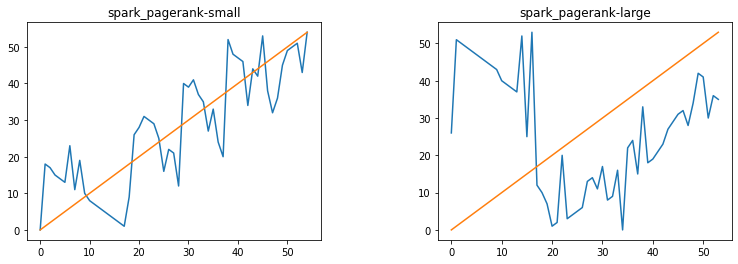

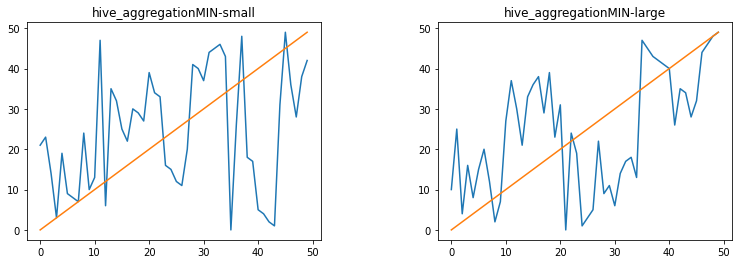

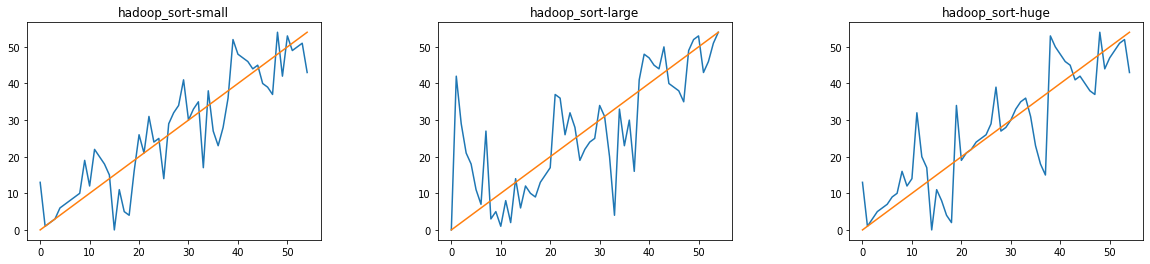

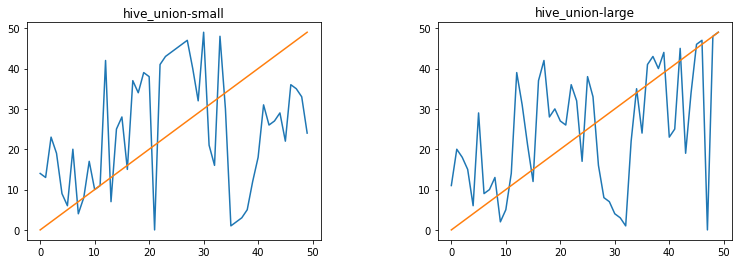

<Figure size 1440x288 with 0 Axes>

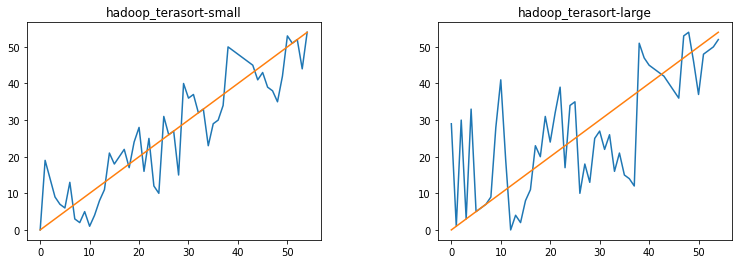

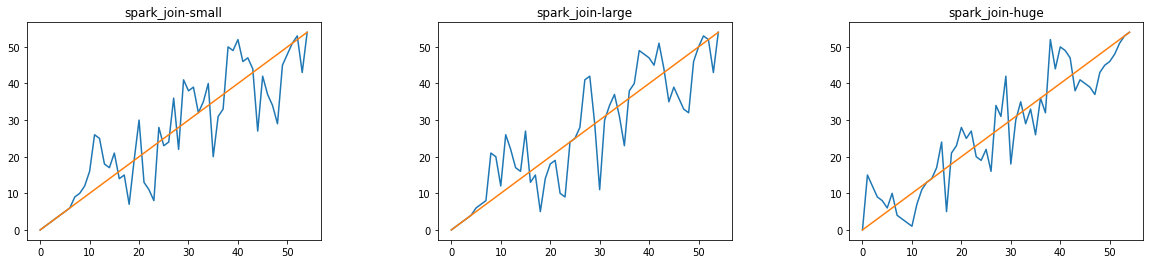

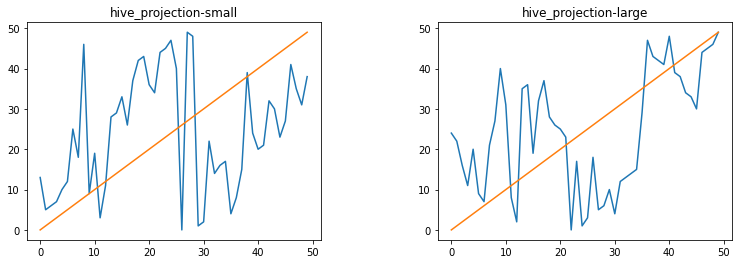

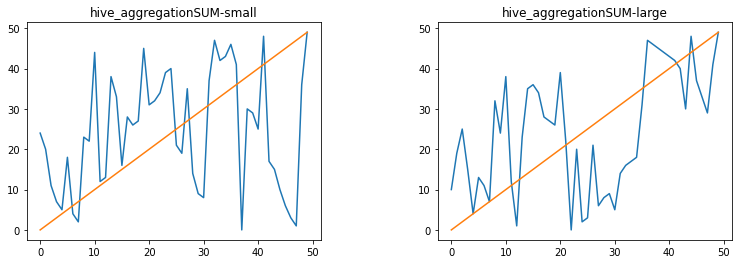

In [11]:
workloads = data['1'].keys()
test_rank_bars = defaultdict(lambda: defaultdict(lambda: None))
for wl in workloads:
    train_data, test_data = data_loader.get_train_test_data_external(test_wl=wl, train_scale='small', ordinal=True)
    train_X = train_data['1']['g6.large']['X']
    train_Y = train_data['1']['g6.large']['Y']
    regressor.fit(train_X, train_Y)
    cnt = 1
    fig = plt.figure(figsize=(20, 4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for scale, test_X_Y in test_data['1']['g6.large'].items():
        test_X = test_X_Y['X']
        test_Y = test_X_Y['Y']
        test_Y_bar = regressor.predict(test_X)
        test_rank_bar = np.argsort(test_Y_bar)
        test_rank_bars[wl][scale] = test_rank_bar
        ax = fig.add_subplot(1, 3, cnt)
        ax.set_title('%s-%s' % (wl, scale))
        ax.plot(test_rank_bar)
        ax.plot(np.arange(len(test_rank_bar)))
        cnt += 1
    plt.show()

### top1, top3, top5, top9

In [379]:
scal_cnts = defaultdict(lambda: 0)
top1_cnts = defaultdict(lambda: 0)
top3_cnts = defaultdict(lambda: 0)
top5_cnts = defaultdict(lambda: 0)
top9_cnts = defaultdict(lambda: 0)
hi_workloads = []
for wl, wl_data in test_rank_bars.items():
    if 'hive' in wl: continue
    hi_workloads.append(wl)
    for scale, scale_data in wl_data.items():
        if scale_data[0] >= 9:
            print(wl, scale, scale_data[0])
        scal_cnts[scale] += 1
        if scale_data[0] == 0: top1_cnts[scale] += 1
        if scale_data[0] < 3: top3_cnts[scale] += 1
        if scale_data[0] < 5: top5_cnts[scale] += 1
        if scale_data[0] < 9: top9_cnts[scale] += 1
print(hi_workloads)

hadoop_pagerank large 33
hadoop_dfsioe-write huge 9
spark_pagerank large 26
hadoop_sort small 13
hadoop_sort huge 13
hadoop_terasort large 29
['spark_logisticregression', 'spark_terasort', 'hadoop_scan', 'spark_wordcount', 'hadoop_pagerank', 'hadoop_dfsioe-read', 'spark_bayes', 'spark_scan', 'spark_sort', 'hadoop_dfsioe-write', 'hadoop_join', 'hadoop_aggregation', 'spark_aggregation', 'spark_pagerank', 'hadoop_sort', 'hadoop_terasort', 'spark_join']


In [285]:
scal_cnts

defaultdict(<function __main__.<lambda>()>,
            {'small': 17, 'large': 17, 'huge': 12})

In [286]:
top1_cnts

defaultdict(<function __main__.<lambda>()>,
            {'small': 16, 'large': 12, 'huge': 10})

In [287]:
top3_cnts

defaultdict(<function __main__.<lambda>()>,
            {'small': 16, 'large': 14, 'huge': 10})

In [22]:
top5_cnts

defaultdict(<function __main__.<lambda>()>,
            {'small': 16, 'large': 14, 'huge': 10})

In [23]:
top9_cnts

defaultdict(<function __main__.<lambda>()>,
            {'small': 16, 'large': 14, 'huge': 10})

In [316]:
rank_data = data_loader.get_data_rankize()

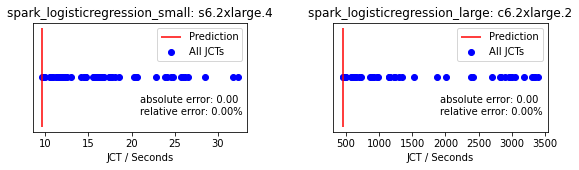

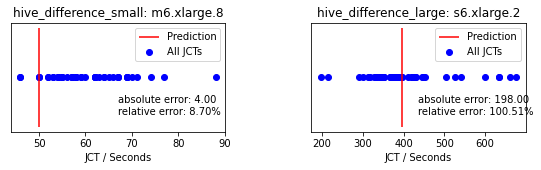

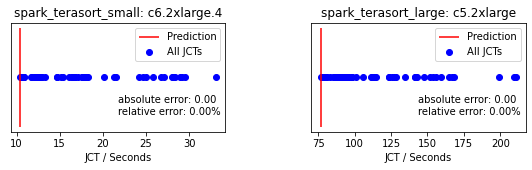

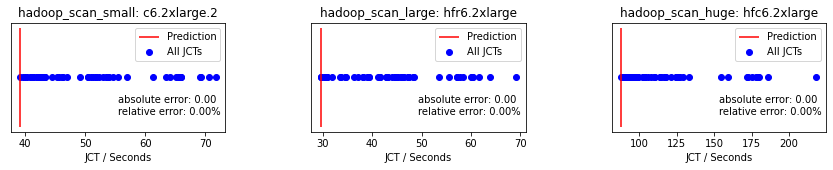

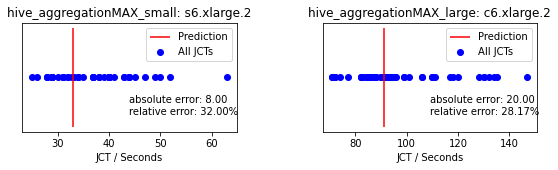

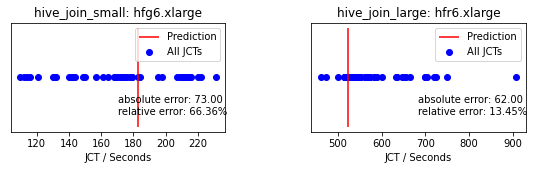

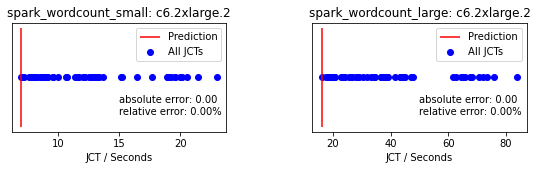

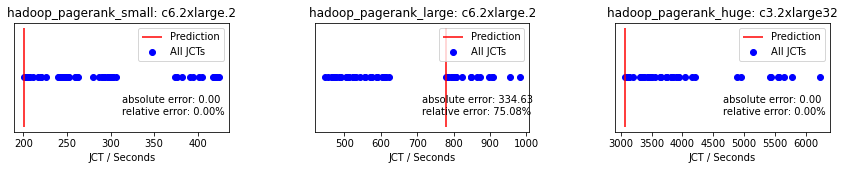

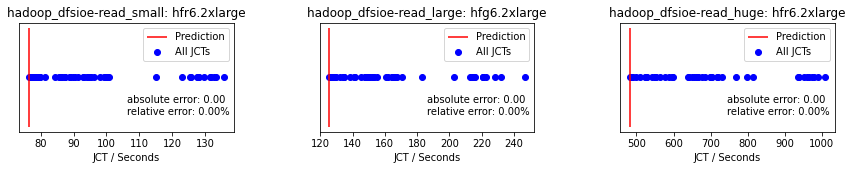

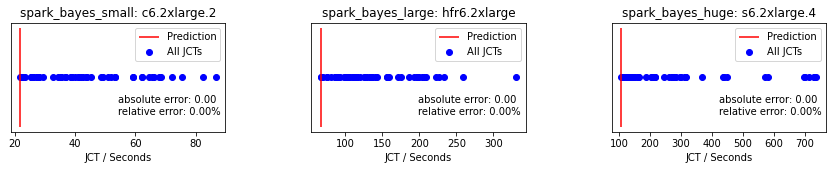

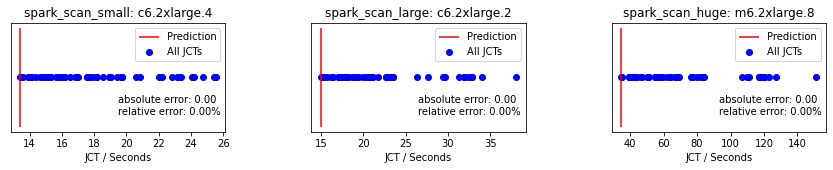

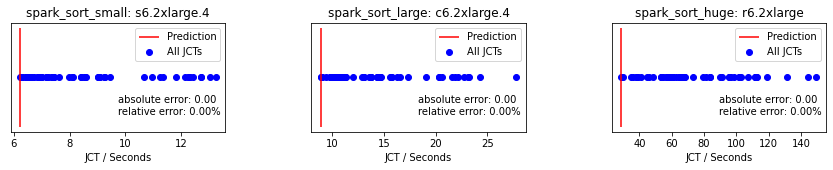

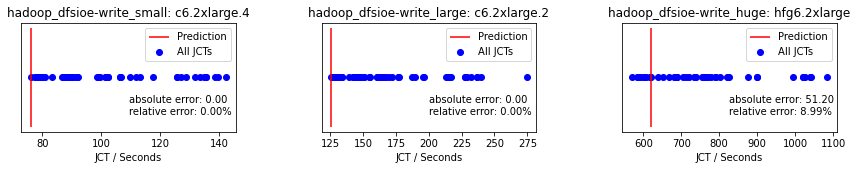

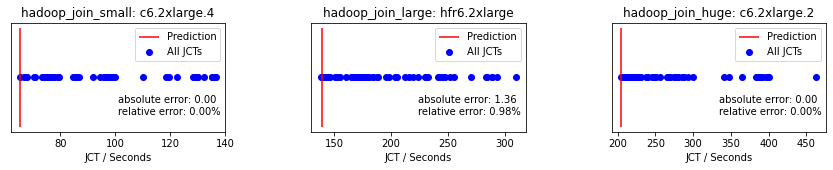

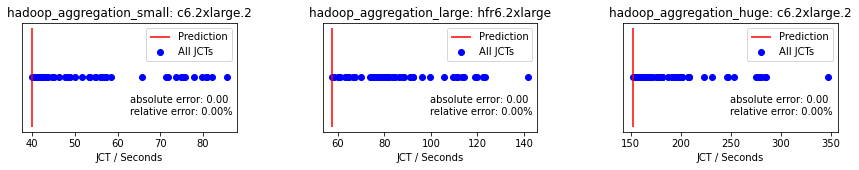

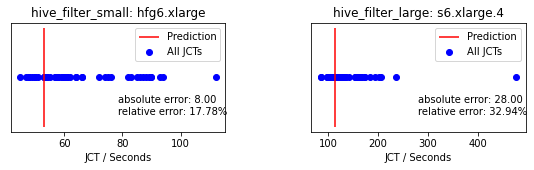

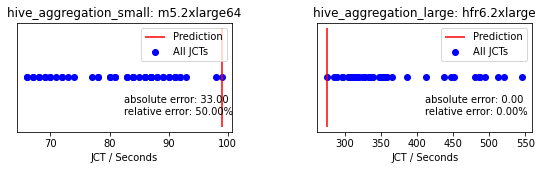

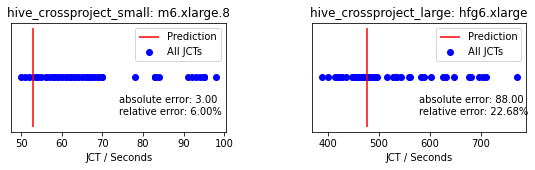

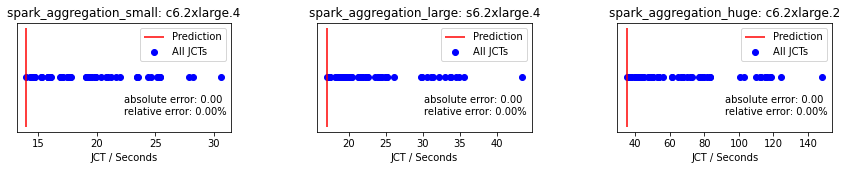

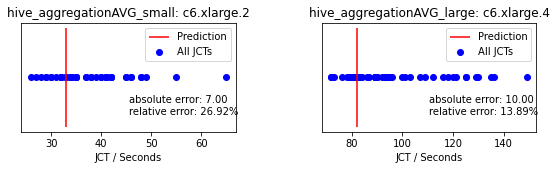

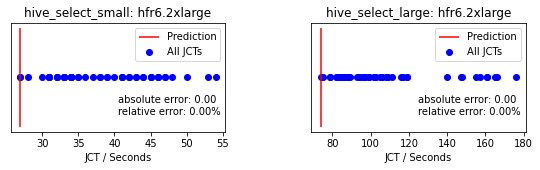

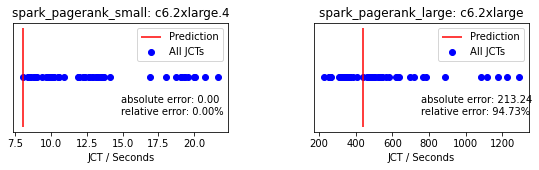

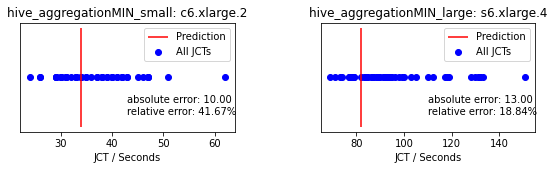

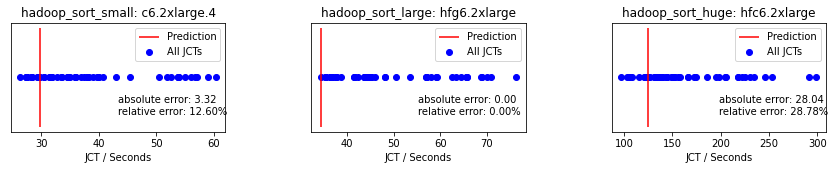

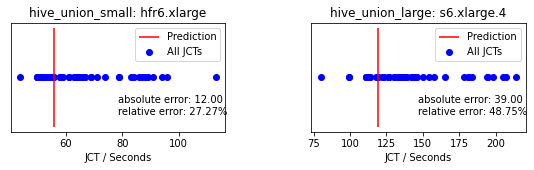

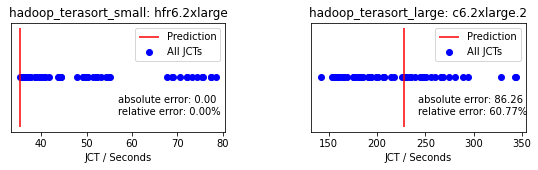

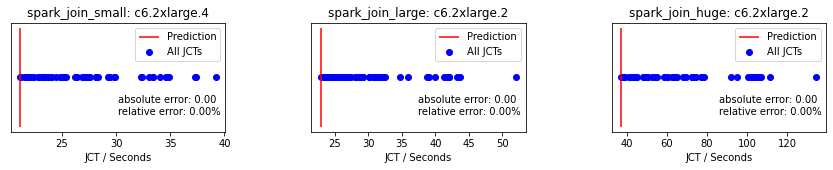

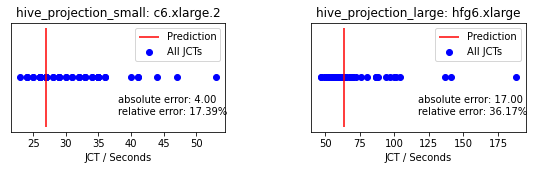

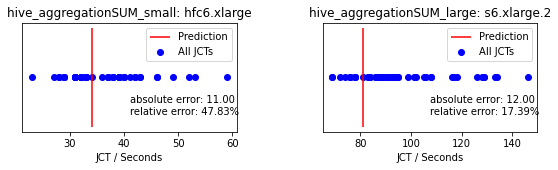

In [317]:
s = set()
for wl, wl_data in test_rank_bars.items():
    cnt = 1
    plt.figure(figsize=(20,2))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    for scale, scale_data in wl_data.items():
        pred_idx = scale_data[0]
        pred_jct = rank_data['1'][wl][scale][pred_idx].jct
        pred_inst_type = rank_data['1'][wl][scale][pred_idx].inst_type
        s.add(pred_inst_type)
        other_jcts = [record.jct for record in rank_data['1'][wl][scale]]
        ab_err = abs(pred_jct - other_jcts[0])
        re_err = ab_err / other_jcts[0] * 100
        plt.subplot(1, 4, cnt)
        plt.title('%s_%s: %s' % (wl, scale, pred_inst_type))
        plt.vlines(pred_jct, -0.01, 0.01, color='red', label='Prediction')
        plt.scatter(other_jcts, np.zeros(len(other_jcts)), color='blue', label='All JCTs')
        plt.text((other_jcts[0] + other_jcts[-1]) / 2, -0.0075, 'absolute error: %.2f\nrelative error: %.2f%%' % (ab_err, re_err))
        plt.yticks([])
        plt.xlabel('JCT / Seconds')
        plt.legend()
        cnt += 1
    plt.show()

In [28]:
print(len(s))

18


In [22]:
test_rank_bars['spark_pagerank']['large']

array([ 0, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 28, 27, 26, 25,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 52, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 13, 53])

In [23]:
rank_data['1']['spark_pagerank']['large'][22].jct

367.138

In [24]:
rank_data['1']['spark_pagerank']['large'][0].jct

225.103

In [25]:
rank_data['1']['spark_pagerank']['large'][22].inst_type

'r5.xlarge'

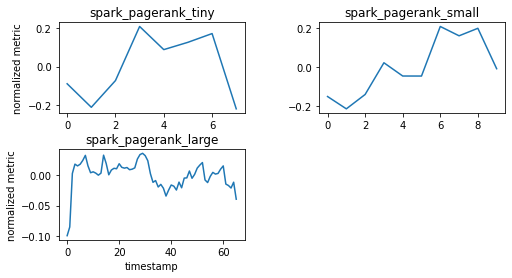

In [33]:
sp_metrics = [data['1']['spark_pagerank'][scale][0].metrics[:, 0] for scale in ['tiny', 'small', 'large']]
cnt = 1
plt.figure(figsize=(8,4))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for scale, metrics in zip(['tiny', 'small', 'large'], sp_metrics):
    plt.subplot(2, 2, cnt)
    if cnt % 2:
        plt.ylabel('normalized metric')
    if cnt > 2:
        plt.xlabel('timestamp')
    plt.title('spark_pagerank_%s' % scale)
    plt.plot(metrics)
    cnt += 1

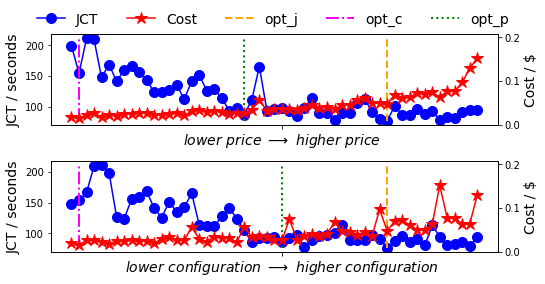

In [4]:
wl = 'spark_terasort'
wl_data = data['1'][wl]
test_ana_origin = wl_data['huge']
scale = 'huge'
if not test_ana_origin:
    test_ana_origin = wl_data['large']
    scale = 'large'

# vertical lines endpoints factors
down_factor, up_factor = 0.6, 1.3

# sort by hourly price
test_ana = sorted(test_ana_origin, key=lambda x: conf.get_inst_hourly_price(x.inst_type))
values = [record.jct for record in test_ana]
opt_j_x, opt_j = np.argmin(values), np.min(values)
costs = [record.jct / 3600 * conf.get_inst_hourly_price(record.inst_type) for record in test_ana]
opt_c_x, opt_c = np.argmin(costs), np.min(costs)
pcr = [1 / v / c for v, c in zip(values, costs)]
opt_p_x, opt_p = np.argmax(pcr), np.max(pcr)

x = [i for i in range(len(test_ana))]

fig = plt.figure(figsize=(8,4))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
ax1 = fig.add_subplot(211)
ax1.plot(x, values, color='blue', marker='o', ms=10, label='JCT')
ax1.set_ylabel('JCT / seconds', fontsize=fontsize)

ax2 = ax1.twinx()
ax2.plot(x, costs, color='red', marker='*', ms=12, label='Cost')

ax2.vlines(opt_j_x, down_factor * np.min(costs), up_factor * np.max(costs), label='opt_j', linestyles='--', linewidth=2, color='orange')
ax2.vlines(opt_c_x, down_factor * np.min(costs), up_factor * np.max(costs), label='opt_c', linestyles='-.', linewidth=2, color='magenta')
ax2.vlines(opt_p_x, down_factor * np.min(costs), up_factor * np.max(costs), label='opt_p', linestyles=':', linewidth=2, color='green')


ax2.set_ylabel('Cost / $', fontsize=fontsize)
ax1.set_xticks([(len(x) + 1) // 2])
ax1.set_xticklabels([r'$lower\ price\ \longrightarrow\ higher\ price$'], fontsize=fontsize)

# sort by config
test_ana = sorted(test_ana_origin, key=lambda x: (conf.get_inst_detailed_conf(x.inst_type)['cpu'], \
                                                  conf.get_inst_detailed_conf(x.inst_type)['memory']))
values = [record.jct for record in test_ana]
opt_j_x, opt_j = np.argmin(values), np.min(values)
costs = [record.jct / 3600 * conf.get_inst_hourly_price(record.inst_type) for record in test_ana]
opt_c_x, opt_c = np.argmin(costs), np.min(costs)
pcr = [1 / v / c for v, c in zip(values, costs)]
opt_p_x, opt_p = np.argmax(pcr), np.max(pcr)

ax3 = fig.add_subplot(212)
ax3.plot(x, values, color='blue', marker='o', ms=10)
ax3.set_ylabel('JCT / seconds', fontsize=fontsize)
ax4 = ax3.twinx()
ax4.plot(x, costs, color='red', marker='*', ms=12)
ax4.vlines(opt_j_x, down_factor * np.min(costs), up_factor * np.max(costs), linestyles='--', linewidth=2, color='orange')
ax4.vlines(opt_c_x, down_factor * np.min(costs), up_factor * np.max(costs), linestyles='-.', linewidth=2, color='magenta')
ax4.vlines(opt_p_x, down_factor * np.min(costs), up_factor * np.max(costs), linestyles=':', linewidth=2, color='green')
ax4.set_ylabel('Cost / $', fontsize=fontsize)
ax3.set_xticks([(len(x) + 1) // 2])
ax3.set_xticklabels([r'$lower\ configuration\ \longrightarrow\ higher\ configuration$'], fontsize=fontsize)
fig.legend(loc=9, ncol=5, fontsize=fontsize, frameon=False)

#fig.suptitle('%s, scale=%s' % (wl, scale))
#plt.savefig('figures/mis_conf_effect.pdf', dpi=441)
plt.show()

spark_logisticregression


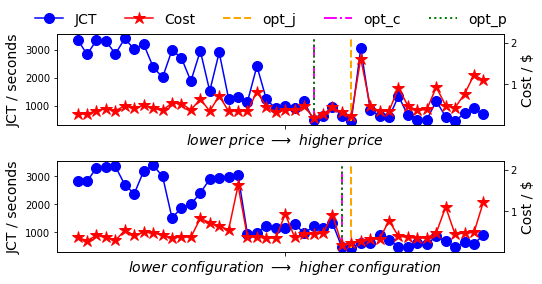

hive_difference


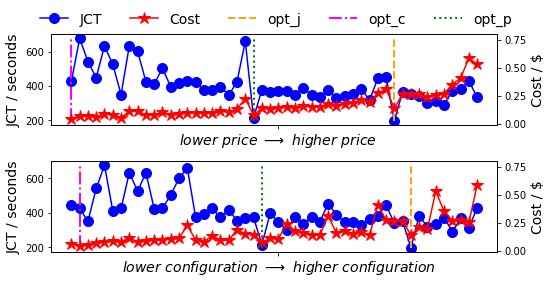

spark_terasort


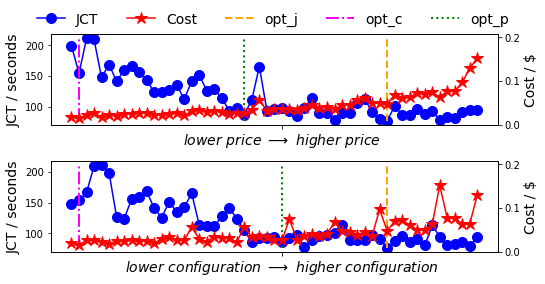

hadoop_scan


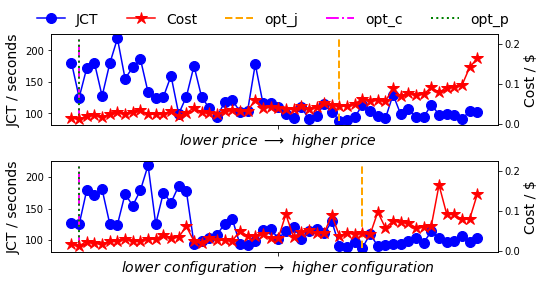

hive_aggregationMAX


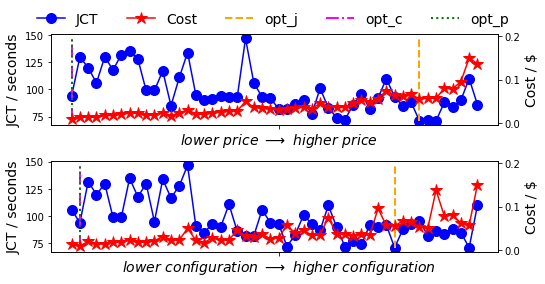

hive_join


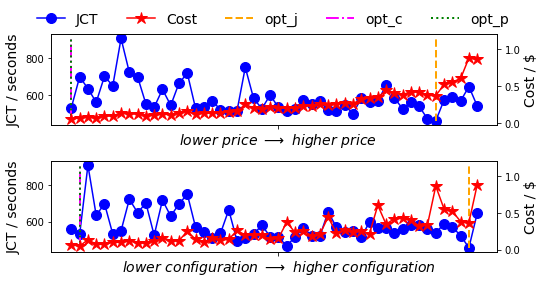

spark_wordcount


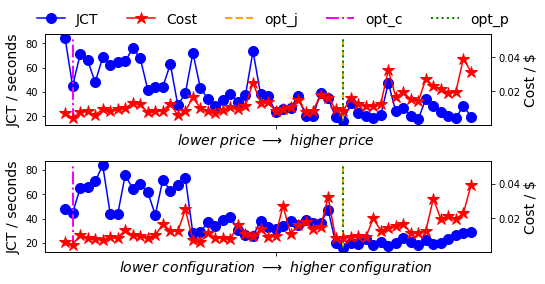

hadoop_pagerank


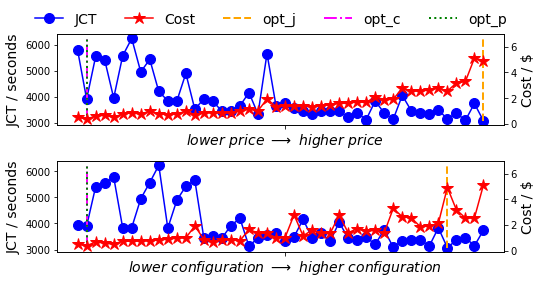

hadoop_dfsioe-read


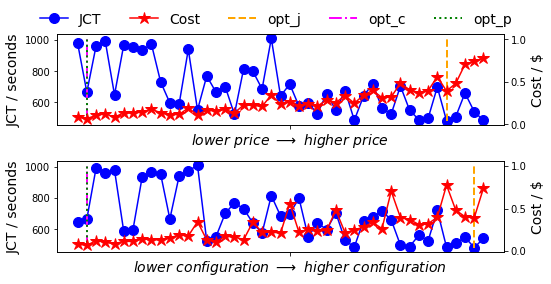

spark_bayes


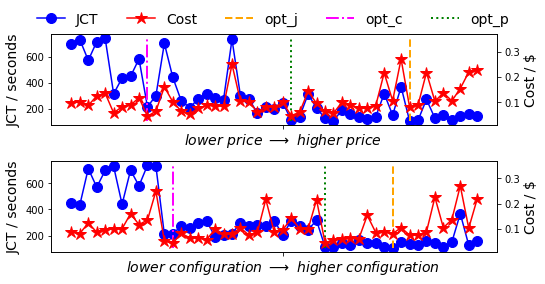

spark_scan


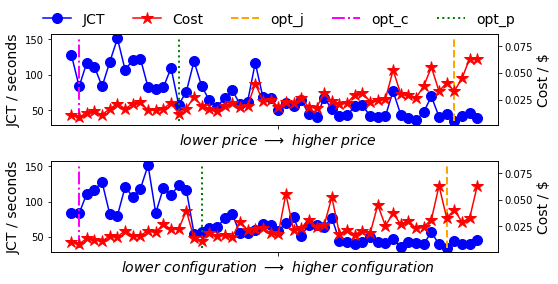

spark_sort


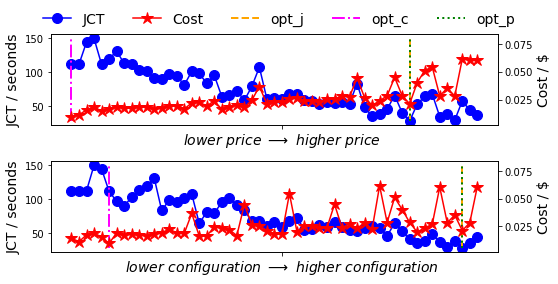

hadoop_dfsioe-write


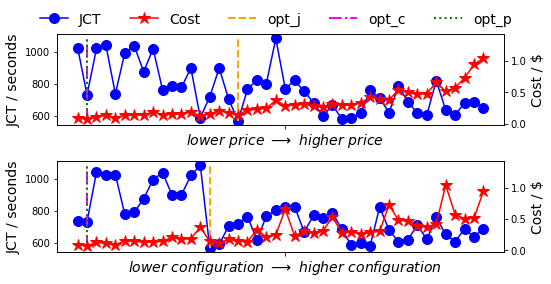

hadoop_join


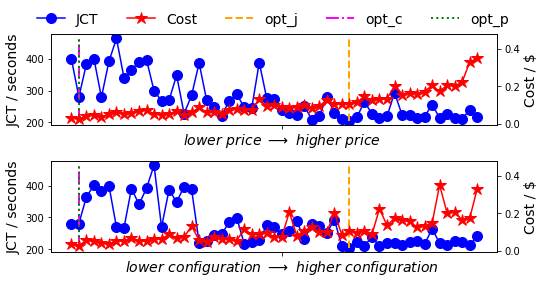

hadoop_aggregation


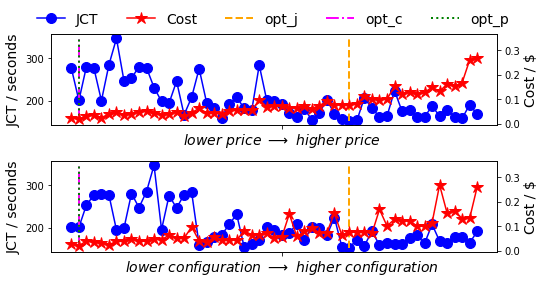

hive_filter


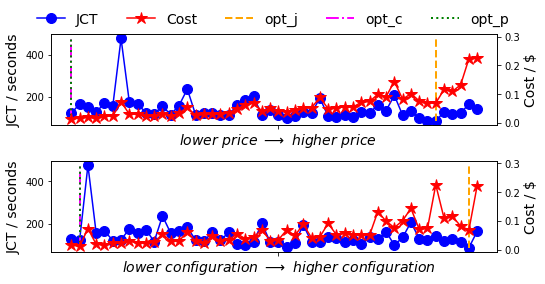

hive_aggregation


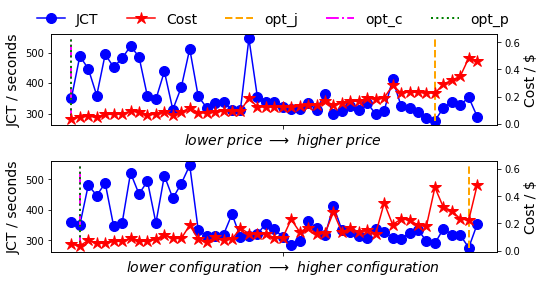

hive_crossproject


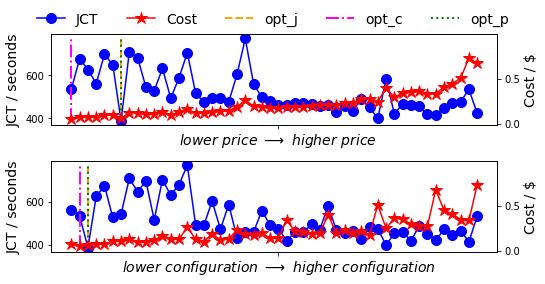

spark_aggregation


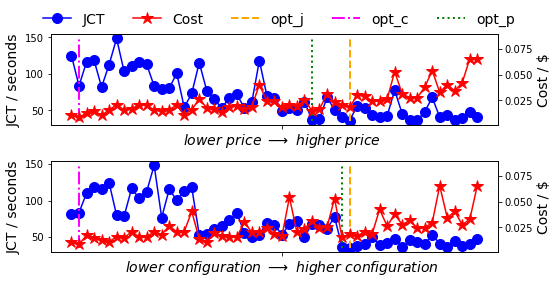

hive_aggregationAVG


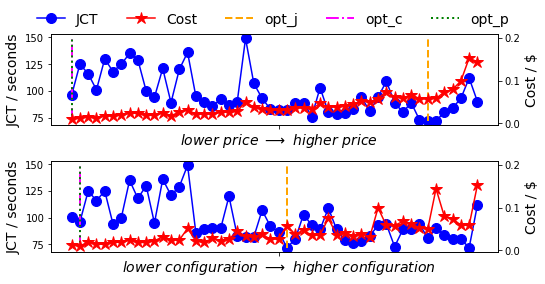

hive_select


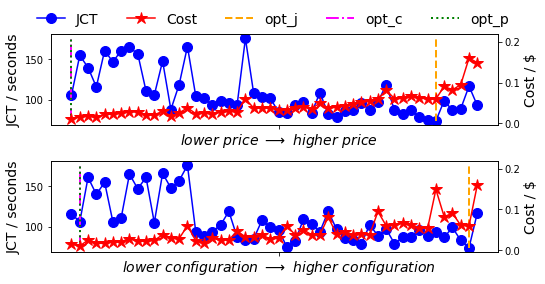

spark_pagerank


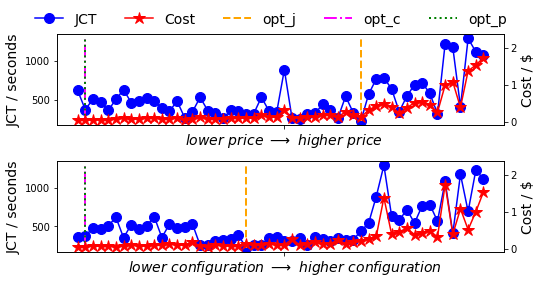

hive_aggregationMIN


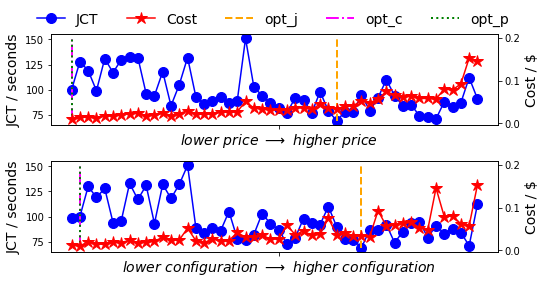

hadoop_sort


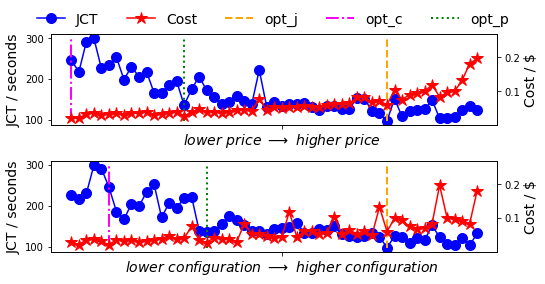

hive_union


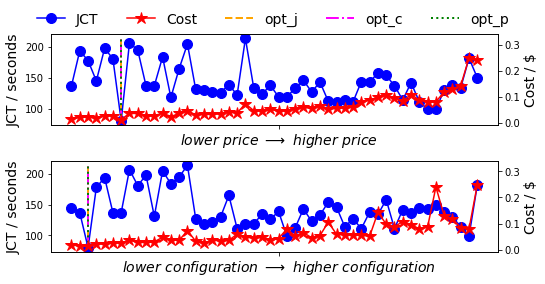

spark_als


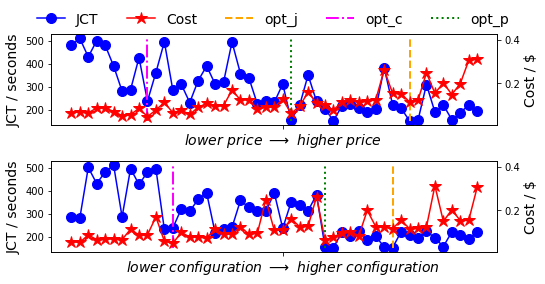

hadoop_terasort


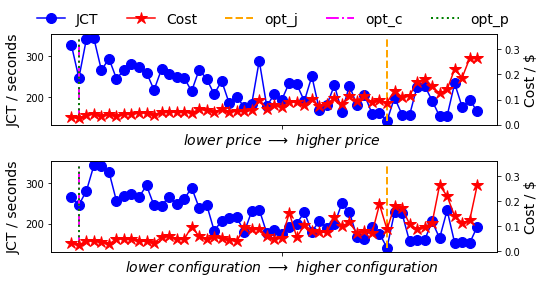

spark_join


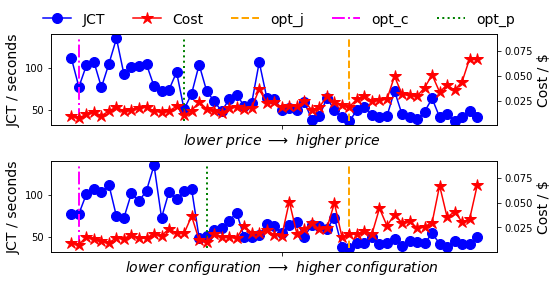

hive_projection


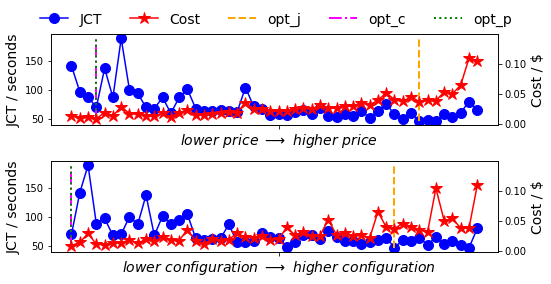

hive_aggregationSUM


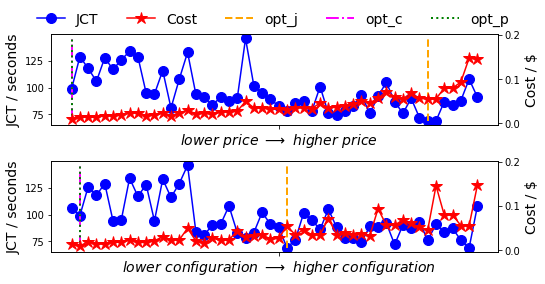

In [24]:
for wl in data['1'].keys():
    # wl = 'spark_terasort'
    print(wl)
    wl_data = data['1'][wl]
    test_ana_origin = wl_data['huge']
    scale = 'huge'
    if not test_ana_origin:
        test_ana_origin = wl_data['large']
        scale = 'large'

    # vertical lines endpoints factors
    down_factor, up_factor = 0.6, 1.3

    # sort by hourly price
    test_ana = sorted(test_ana_origin, key=lambda x: conf.get_inst_hourly_price(x.inst_type))
    values = [record.jct for record in test_ana]
    opt_j_x, opt_j = np.argmin(values), np.min(values)
    costs = [record.jct / 3600 * conf.get_inst_hourly_price(record.inst_type) for record in test_ana]
    opt_c_x, opt_c = np.argmin(costs), np.min(costs)
    pcr = [1 / v / c for v, c in zip(values, costs)]
    opt_p_x, opt_p = np.argmax(pcr), np.max(pcr)

    x = [i for i in range(len(test_ana))]

    fig = plt.figure(figsize=(8,4))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    ax1 = fig.add_subplot(211)
    ax1.plot(x, values, color='blue', marker='o', ms=10, label='JCT')
    ax1.set_ylabel('JCT / seconds', fontsize=fontsize)

    ax2 = ax1.twinx()
    ax2.plot(x, costs, color='red', marker='*', ms=12, label='Cost')

    ax2.vlines(opt_j_x, down_factor * np.min(costs), up_factor * np.max(costs), label='opt_j', linestyles='--', linewidth=2, color='orange')
    ax2.vlines(opt_c_x, down_factor * np.min(costs), up_factor * np.max(costs), label='opt_c', linestyles='-.', linewidth=2, color='magenta')
    ax2.vlines(opt_p_x, down_factor * np.min(costs), up_factor * np.max(costs), label='opt_p', linestyles=':', linewidth=2, color='green')


    ax2.set_ylabel('Cost / $', fontsize=fontsize)
    ax1.set_xticks([(len(x) + 1) // 2])
    ax1.set_xticklabels([r'$lower\ price\ \longrightarrow\ higher\ price$'], fontsize=fontsize)

    # sort by config
    test_ana = sorted(test_ana_origin, key=lambda x: (conf.get_inst_detailed_conf(x.inst_type)['cpu'], \
                                                      conf.get_inst_detailed_conf(x.inst_type)['memory']))
    values = [record.jct for record in test_ana]
    opt_j_x, opt_j = np.argmin(values), np.min(values)
    costs = [record.jct / 3600 * conf.get_inst_hourly_price(record.inst_type) for record in test_ana]
    opt_c_x, opt_c = np.argmin(costs), np.min(costs)
    pcr = [1 / v / c for v, c in zip(values, costs)]
    opt_p_x, opt_p = np.argmax(pcr), np.max(pcr)

    ax3 = fig.add_subplot(212)
    ax3.plot(x, values, color='blue', marker='o', ms=10)
    ax3.set_ylabel('JCT / seconds', fontsize=fontsize)
    ax4 = ax3.twinx()
    ax4.plot(x, costs, color='red', marker='*', ms=12)
    ax4.vlines(opt_j_x, down_factor * np.min(costs), up_factor * np.max(costs), linestyles='--', linewidth=2, color='orange')
    ax4.vlines(opt_c_x, down_factor * np.min(costs), up_factor * np.max(costs), linestyles='-.', linewidth=2, color='magenta')
    ax4.vlines(opt_p_x, down_factor * np.min(costs), up_factor * np.max(costs), linestyles=':', linewidth=2, color='green')
    ax4.set_ylabel('Cost / $', fontsize=fontsize)
    ax3.set_xticks([(len(x) + 1) // 2])
    ax3.set_xticklabels([r'$lower\ configuration\ \longrightarrow\ higher\ configuration$'], fontsize=fontsize)
    fig.legend(loc=9, ncol=5, fontsize=fontsize, frameon=False)

    #fig.suptitle('%s, scale=%s' % (wl, scale))
    #plt.savefig('figures/mis_conf_effect.pdf', dpi=441)
    plt.show()

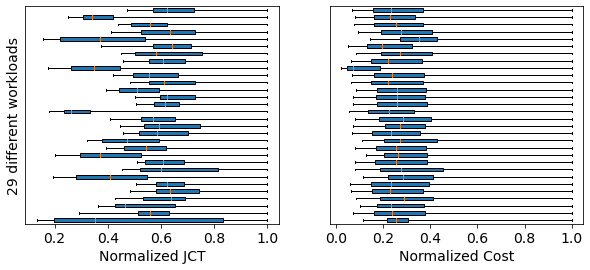

In [90]:
voilin_data_perf = []
voilin_data_cost = []
wl_list = []
for wl in data['1'].keys():
    wl_list.append(wl)
    wl_data = data['1'][wl]['large']
    perf_data = np.array([record.jct for record in wl_data])
    perf_data /= np.max(perf_data)
    cost_data = [record.jct / 3600 * conf.get_inst_hourly_price(record.inst_type) for record in wl_data]
    cost_data /= np.max(cost_data)
    voilin_data_perf.append(perf_data)
    voilin_data_cost.append(cost_data)
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
# ax1.violinplot(voilin_data_perf, showmedians=True, vert=False)
ax1.boxplot(voilin_data_perf, showfliers=False, vert=False, patch_artist=True, whis=10)
ax1.set_xlabel('Normalized JCT', fontsize=fontsize)
ax1.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_xticklabels([0.2, 0.4, 0.6, 0.8, 1.0], fontsize=fontsize)
ax1.set_yticks([])
ax1.set_ylabel('29 different workloads', fontsize=fontsize)

ax2 = fig.add_subplot(1, 2, 2)
# ax2.violinplot(voilin_data_cost, showmedians=True, vert=False)
ax2.boxplot(voilin_data_cost, showfliers=False, vert=False, patch_artist=True, whis=10)
ax2.set_xlabel('Normalized Cost', fontsize=fontsize)
ax2.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_xticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=fontsize)
ax2.set_yticks([])

# plt.grid(linestyle='-.')
# plt.show()
plt.savefig('figures/perf_gap.pdf')

In [93]:
factor_perf = [max(e) / min(e) for e in voilin_data_perf]
factor_cost = [max(e) / min(e) for e in voilin_data_cost]
print(np.mean(factor_perf))
print(np.mean(factor_cost))

3.1139461629390137
14.05113690866685


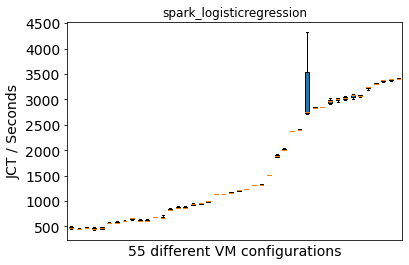

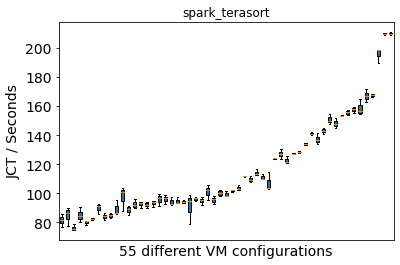

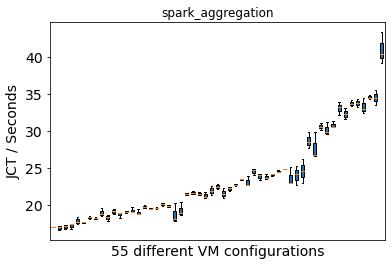

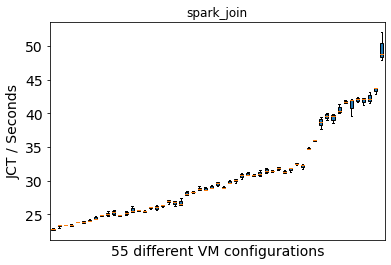

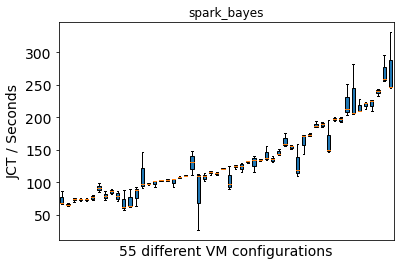

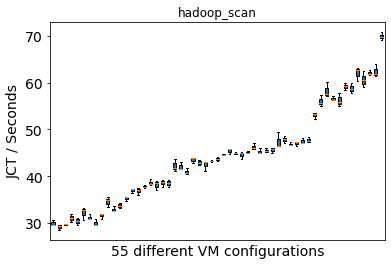

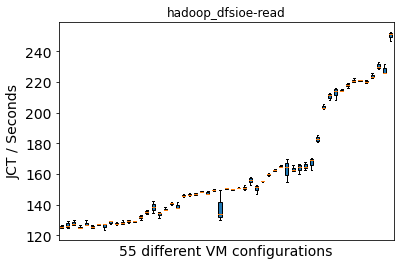

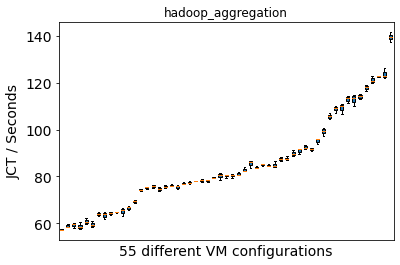

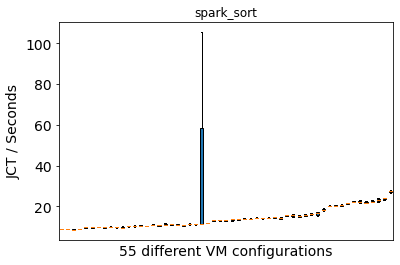

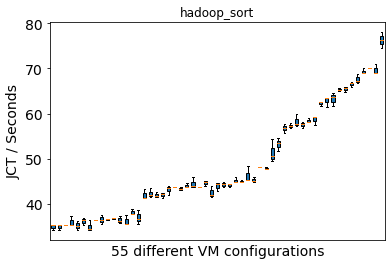

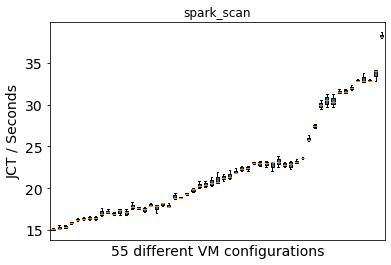

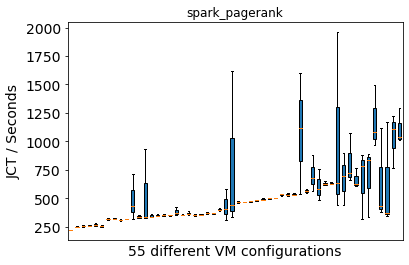

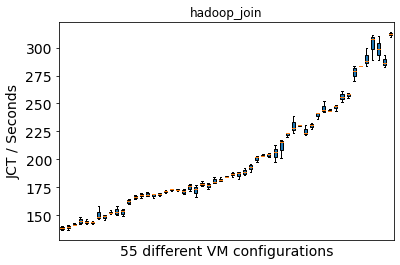

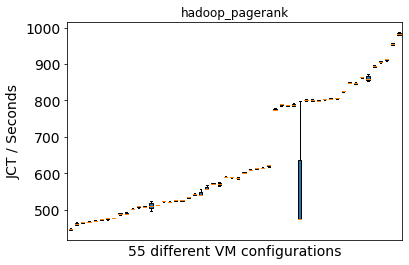

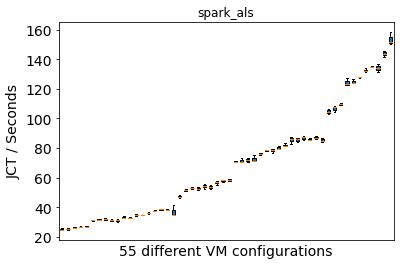

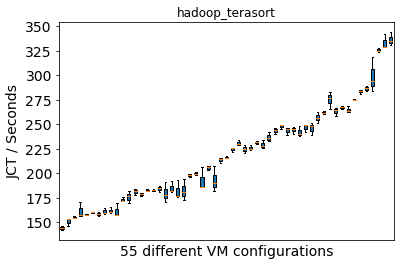

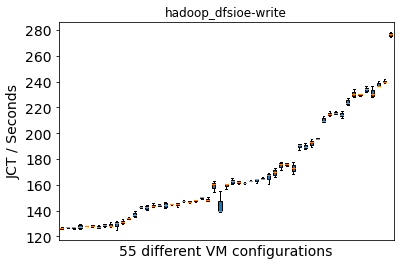

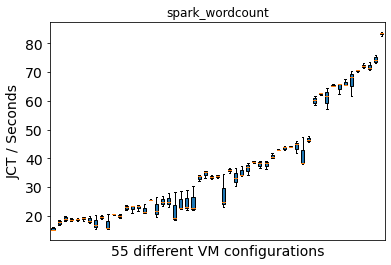

<Figure size 432x288 with 0 Axes>

In [131]:
wl_list_3 = data['1'].keys() and data['2'].keys() and data['3'].keys()
for wl in wl_list_3:
    points_x, points_y = [], []
    cur_x = 0
    # wl = 'hadoop_aggregation'
    jct_data = defaultdict(lambda: [])
    for k in ['1', '2', '3']:
        wl_data = data[k][wl]['large']
        for e in wl_data:
            jct_data[e.inst_type].append(e.jct)
    jct_data = sorted(jct_data.items(), key=lambda x: x[1][0])
    for inst, inst_data in jct_data:
        [points_x.append(cur_x) for _ in range(len(inst_data))]
        cur_x += 1
        points_y.extend(inst_data)
    # plt.scatter(points_x, points_y)
    plt.boxplot([x[1] for x in jct_data], patch_artist=True)
    plt.xticks([])
    plt.yticks(fontsize=14)
    plt.xlabel('55 different VM configurations', fontsize=14)
    plt.ylabel('JCT / Seconds', fontsize=14)
    plt.title(wl)
    plt.show()
    plt.clf()

In [115]:
with open('conf/detail_conf.json', 'r') as fd:
    conf_f = json.load(fd)
conf_f.keys() - jct_data.keys()

set()

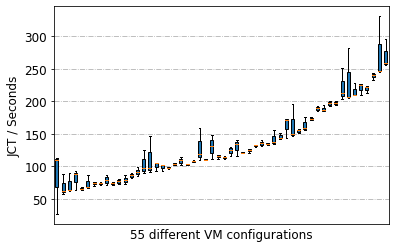

In [144]:
points_x, points_y = [], []
cur_x = 0
wl = 'spark_bayes'
jct_data = defaultdict(lambda: [])
for k in ['1', '2', '3']:
    wl_data = data[k][wl]['large']
    for e in wl_data:
        jct_data[e.inst_type].append(e.jct)
jct_data = sorted(jct_data.items(), key=lambda x: min(x[1]))
for inst, inst_data in jct_data:
    [points_x.append(cur_x) for _ in range(len(inst_data))]
    cur_x += 1
    points_y.extend(inst_data)
# plt.scatter(points_x, points_y)
plt.boxplot([x[1] for x in jct_data], patch_artist=True)
plt.grid(linestyle='-.')
plt.xticks([])
plt.yticks(fontsize=12)
plt.xlabel('55 different VM configurations', fontsize=12)
plt.ylabel('JCT / Seconds', fontsize=12)
# plt.title(wl)
plt.show()
# plt.savefig('figures/unstable_yet_sorted.pdf')

In [149]:
bias = [max(v) - min(v) for k, v in jct_data]

In [52]:
print(wl_list)

['spark_logisticregression', 'hive_difference', 'spark_terasort', 'hadoop_scan', 'hive_aggregationMAX', 'hive_join', 'spark_wordcount', 'hadoop_pagerank', 'hadoop_dfsioe-read', 'spark_bayes', 'spark_scan', 'spark_sort', 'hadoop_dfsioe-write', 'hadoop_join', 'hadoop_aggregation', 'hive_filter', 'hive_aggregation', 'hive_crossproject', 'spark_aggregation', 'hive_aggregationAVG', 'hive_select', 'spark_pagerank', 'hive_aggregationMIN', 'hadoop_sort', 'hive_union', 'spark_als', 'hadoop_terasort', 'spark_join', 'hive_projection', 'hive_aggregationSUM']


In [31]:
max(values) / min(values)

2.7414593547212505

In [32]:
max(costs) / min(costs)

9.858508156993704

In [33]:
prices = [conf.get_inst_hourly_price(x.inst_type) for x in wl_data['large']]

In [34]:
max(prices) / min(prices)

18.58064516129032

In [35]:
len(costs)

55

In [102]:
hive_union_small = data['1']['hive_union']['small'][0].metrics[:,0]
hive_union_large = data['1']['hive_union']['large'][0].metrics[:,0]

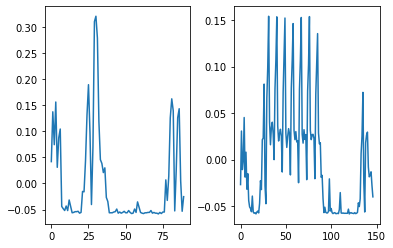

In [104]:
ax1 = plt.subplot(1, 2, 1)
ax1.plot(hive_union_small)
ax2 = plt.subplot(1, 2, 2)
ax2.plot(hive_union_large)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

In [151]:
small_freqs = None
def plot_wave(t_data, extra_info):
    print(extra_info)
    wavename = 'morl'
    total_scal = len(t_data) // 4
    fc = pywt.central_frequency(wavename)
    cparam = 2 * fc * total_scal
    scales = cparam / np.arange(total_scal, 1, -1)
    [cwtmatr, frequencies] = pywt.cwt(t_data, scales, wavename, 1.0 / len(t_data))
    plt.contourf(np.arange(len(t_data)), frequencies, abs(cwtmatr))
    plt.show()
    plt.clf()

In [152]:
def plot_workload_wave(wl):
    w_data = [(scal, scal_data[0].metrics[:, 0]) if scal_data else None for scal, scal_data in data['1'][wl].items()]
    [plot_wave(e[1], '%s-%s' % (wl, e[0])) if e is not None else None for e in w_data]

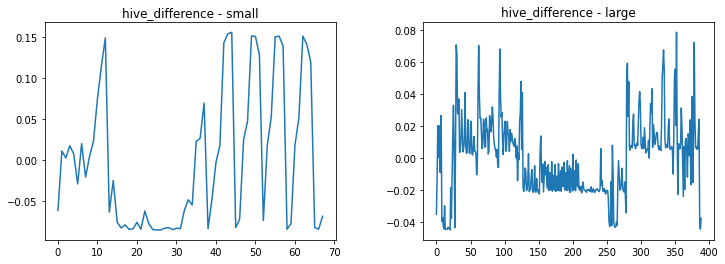

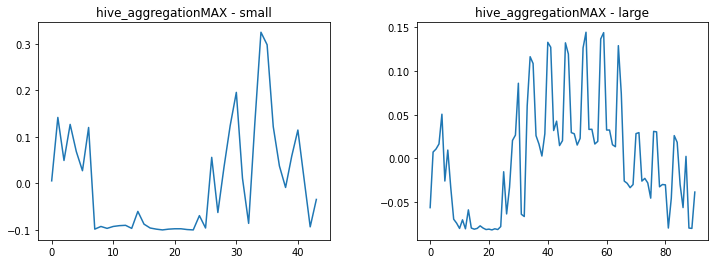

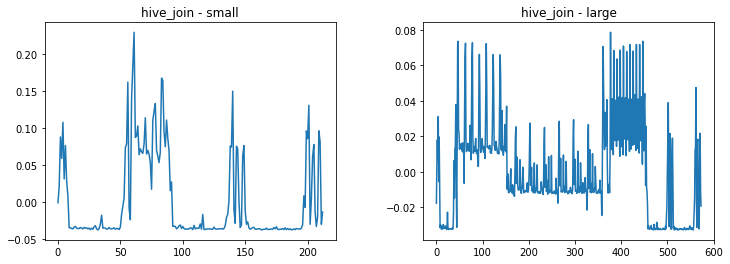

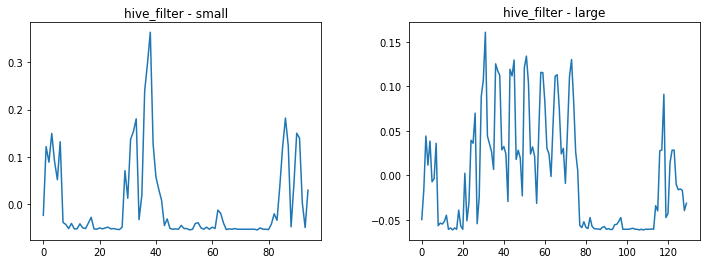

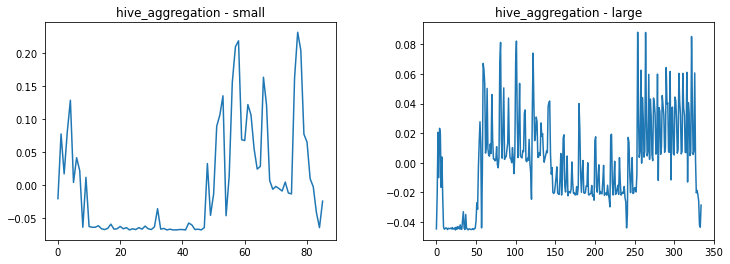

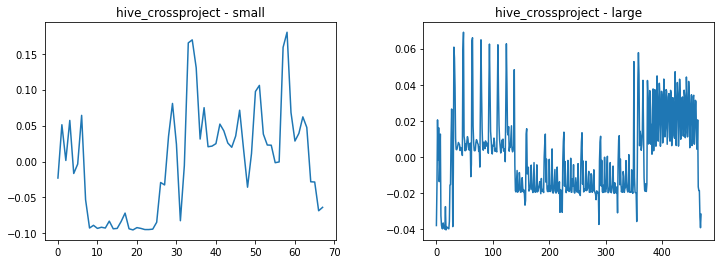

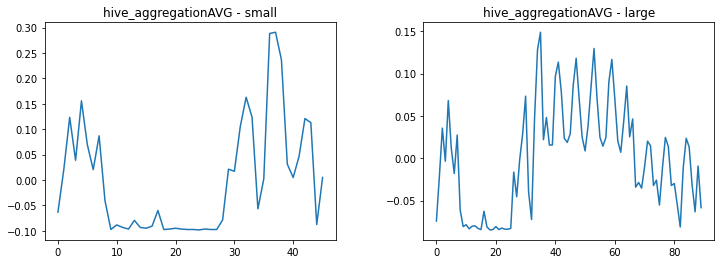

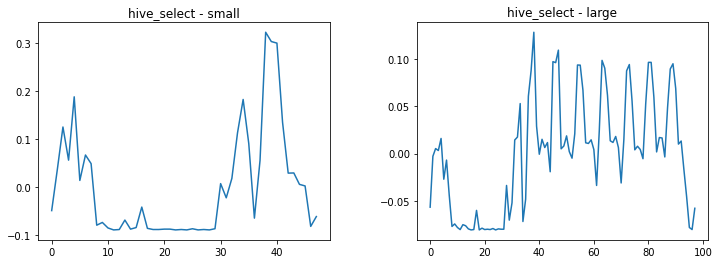

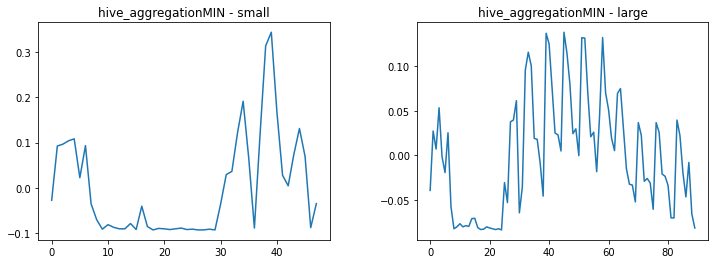

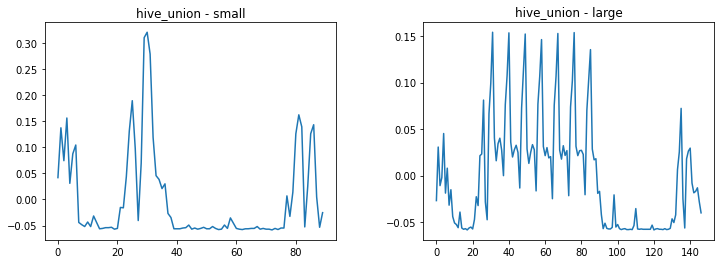

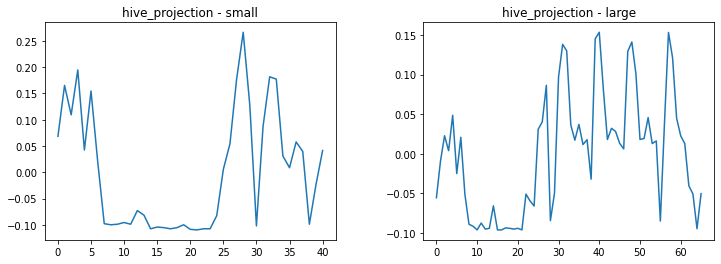

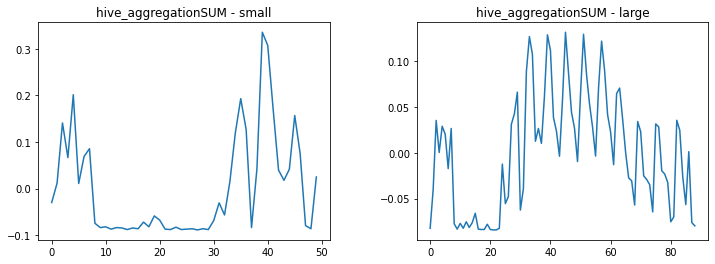

IndexError: list index out of range

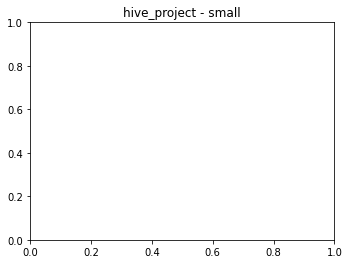

In [160]:
for wl, wl_data in data['1'].items():
    if 'hive' not in wl or 'orderby' in wl or r'project$' in wl: continue
    plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title('%s - small' % wl)
    ax1.plot(wl_data['small'][0].metrics[:, 0])
    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title('%s - large' % wl)
    ax2.plot(wl_data['large'][0].metrics[:, 0])
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.show()

spark_logisticregression


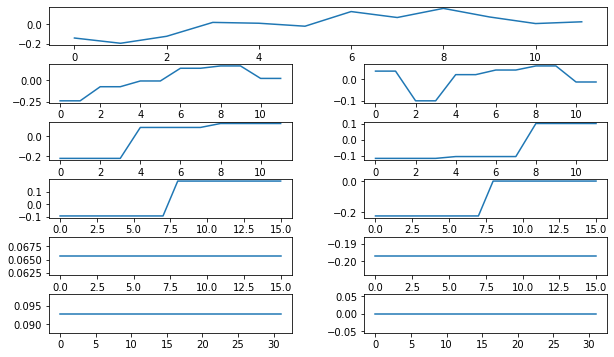

hive_difference


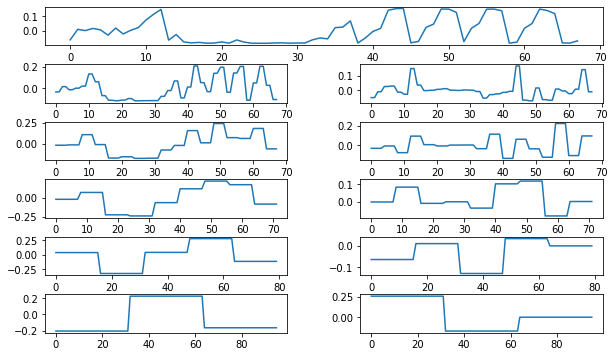

spark_terasort


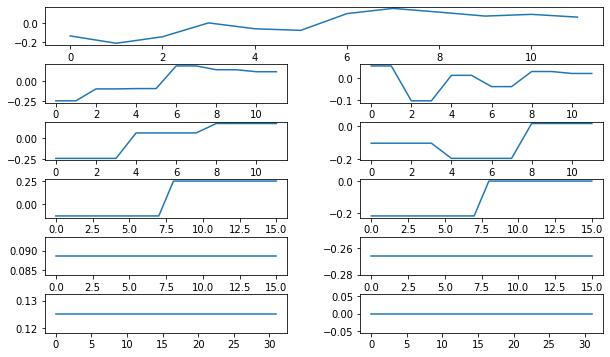

hadoop_scan


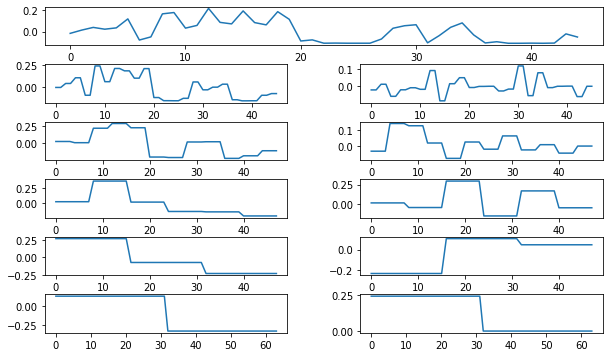

hive_aggregationMAX


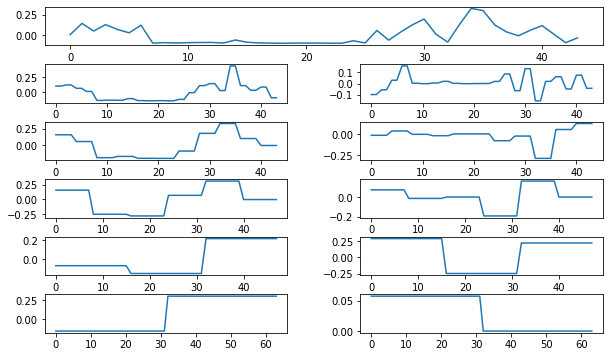

hive_join


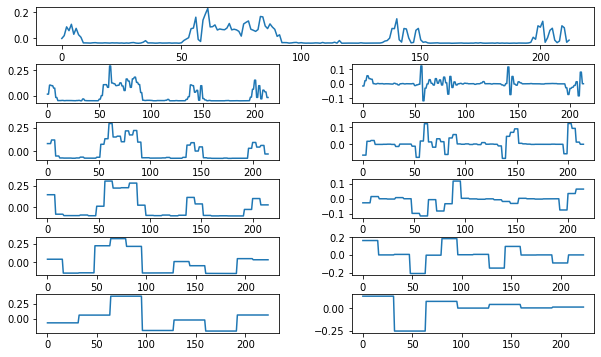

spark_wordcount


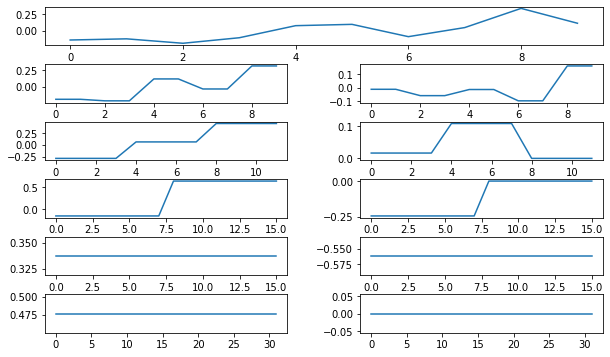

hadoop_pagerank


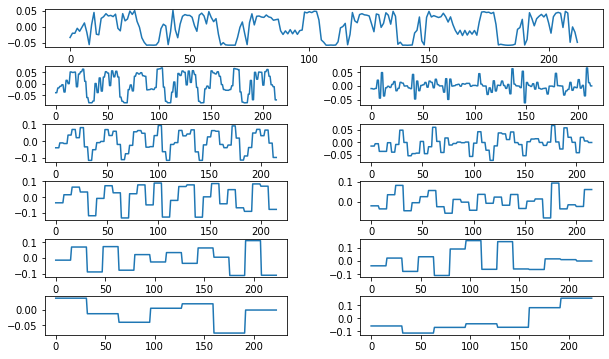

hadoop_dfsioe-read


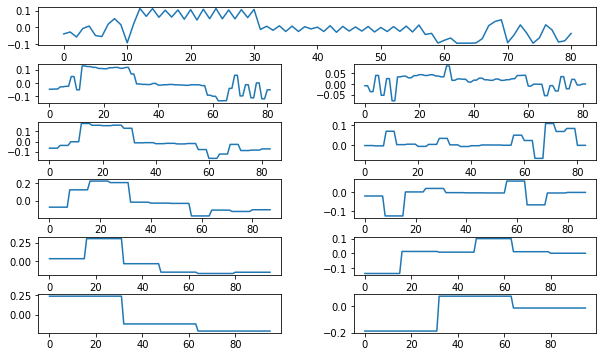

spark_bayes


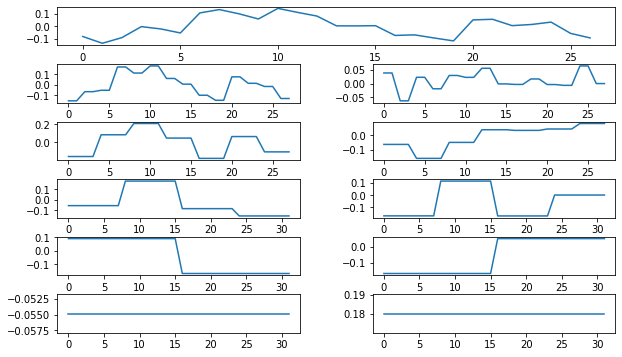

spark_scan


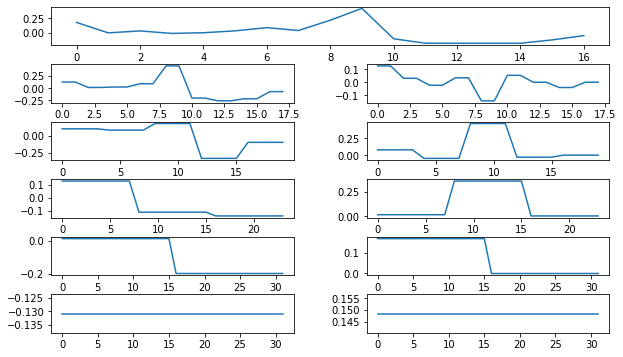

spark_sort


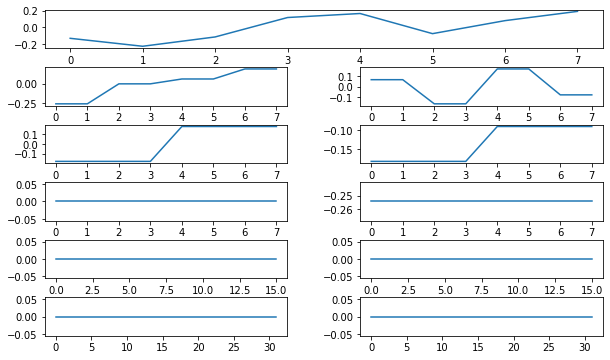

hadoop_dfsioe-write


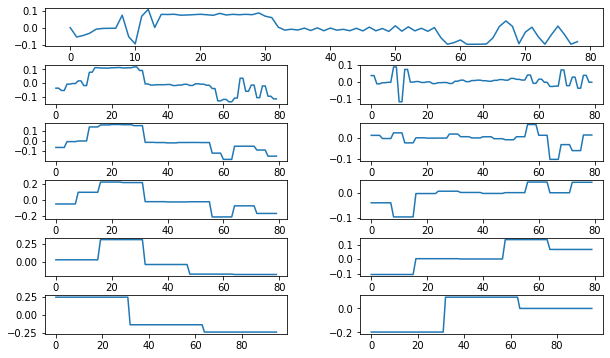

hadoop_join


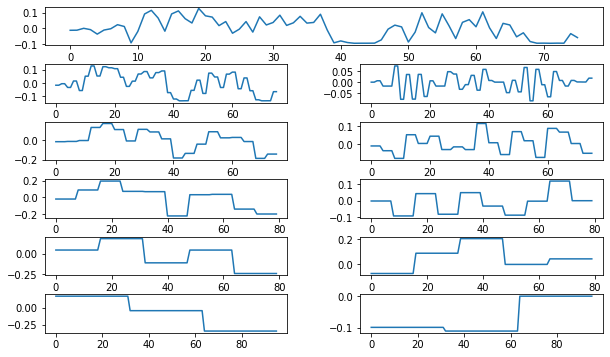

hadoop_aggregation


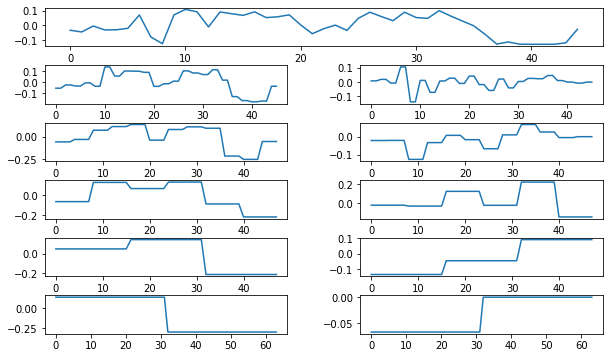

hive_filter


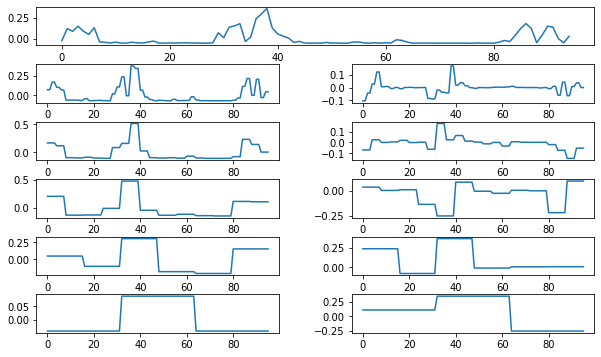

hive_aggregation


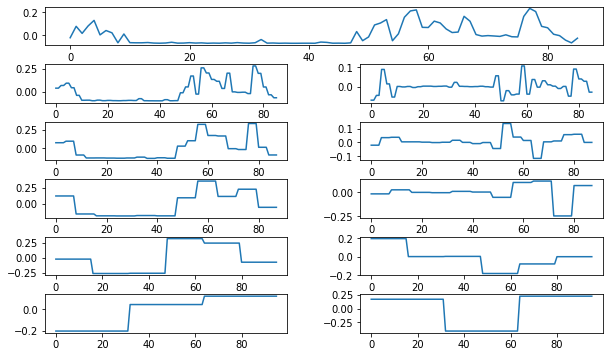

spark_aggregation


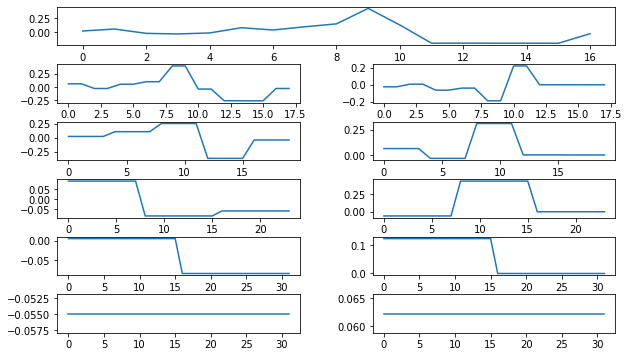

hive_aggregationAVG


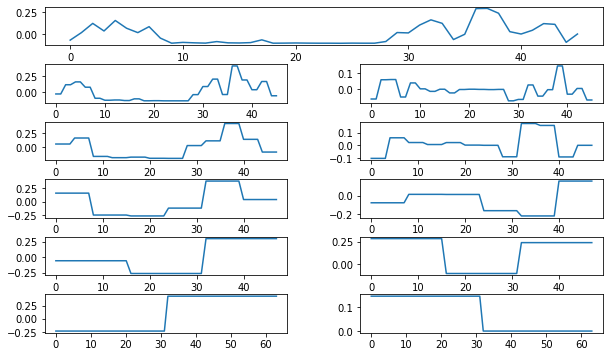

hive_select


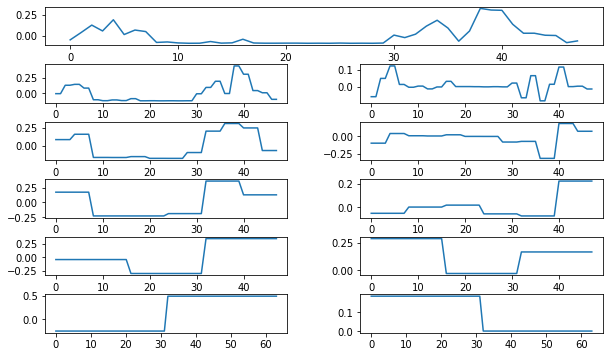

spark_pagerank


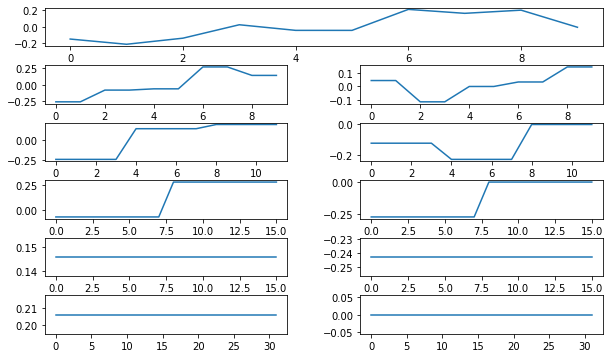

hive_aggregationMIN


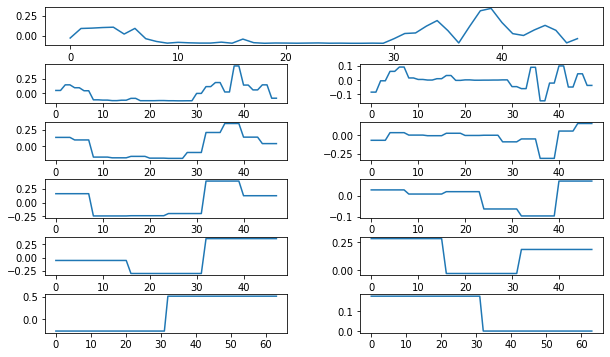

hadoop_sort


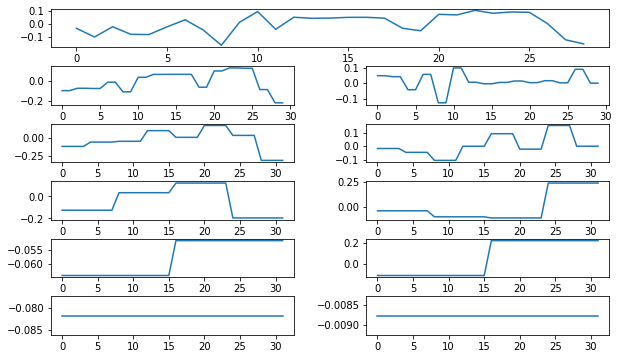

hive_union


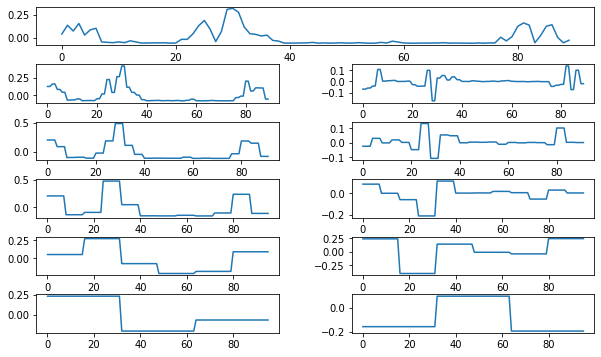

spark_als


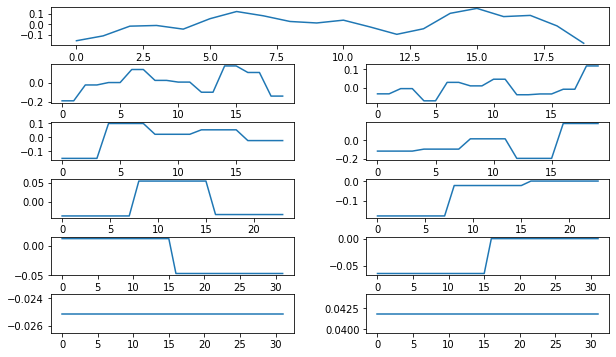

hadoop_terasort


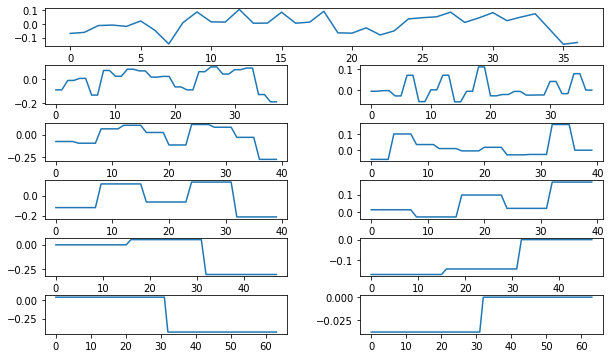

spark_join


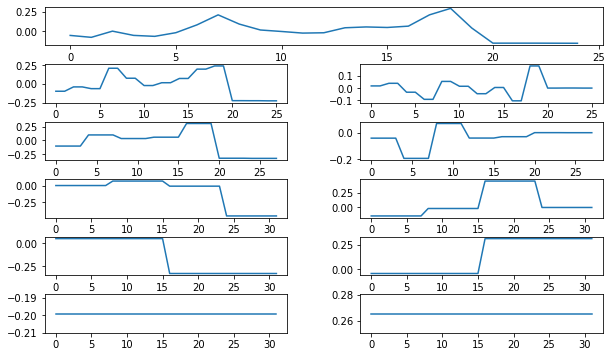

hive_projection


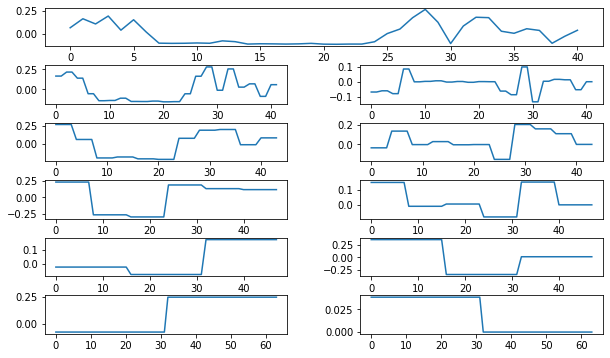

hive_aggregationSUM


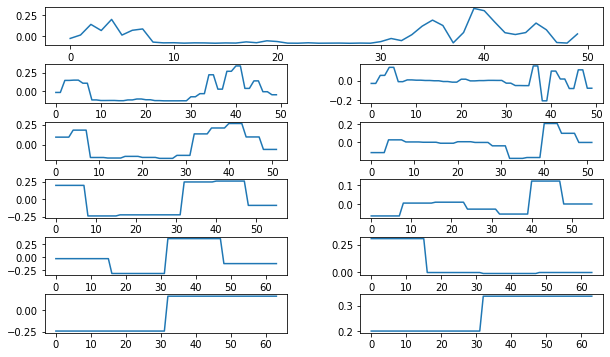

In [229]:
wave_round = 5
for wl, wl_data in data['1'].items():
    if 'orderby' in wl or ('project' in wl and 'projection' not in wl): continue
    print('%s' % wl)
    tmp_data_s = wl_data['small'][0].metrics[:, 0]
    
    coffs_A, coffs_D = [], []
    cA = tmp_data_s
    for i in range(wave_round):
        cA, cD = pywt.dwt(cA, 'haar')
        coffs_A.append(cA)
        coffs_D.append(cD)

    plt.figure(figsize=(10, 6))
    ax0 = plt.subplot(wave_round + 1, 1, 1)
    ax0.plot(tmp_data_s)
    for i in range(wave_round):
        factor = int(2 ** (i + 1))
        tmp_A = []
        for e in coffs_A[i]:
            tmp_A.extend([e] * factor)
        ax2 = plt.subplot(wave_round + 1, 2, (i + 1) * 2 + 1)
        ax2.plot(tmp_A)

        tmp_D = []
        for e in coffs_D[i]:
            tmp_D.extend([e] * factor)
        ax3 = plt.subplot(wave_round + 1, 2, (i + 1) * 2 + 2)
        ax3.plot(tmp_D)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.show()

In [35]:
def key_stage_detect(series_data, n_iter=3, adjacnt_threshold=0.7):
    cA = series_data
    cA_arr = []
    for _ in range(n_iter):
        cA, cD = pywt.dwt(cA, 'haar')
    factor = int(2 ** n_iter)
    max_idx = np.argmax(cA)
    left = max(max_idx - 1, 0)
    right = min(max_idx + 1, len(cA))
    while left > 0 and cA[left - 1] / cA[max_idx] > adjacnt_threshold: left -= 1
    while right < len(cA) and cA[right] / cA[max_idx] > adjacnt_threshold: right += 1
    return left * 2 ** n_iter, min(len(series_data), right * 2 ** n_iter)

In [152]:
to_select_scale = 'large'
metrics_data = []
for wl, wl_data in data['1'].items():
    scale_data = wl_data[to_select_scale]
    metrics_data.append(random.sample(scale_data, 1)[0].metrics)
    # metrics_data.append(scale_data[0].metrics)
# feature_idxes = select_features(metrics_data)
stat_res = ana_metrics(metrics_data)

/data/home/liy/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/data/home/liy/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


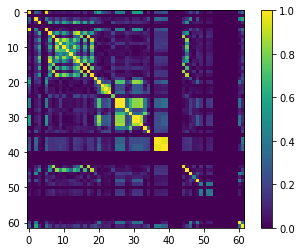

<Figure size 432x288 with 0 Axes>

In [153]:
summation = np.zeros(np.shape(stat_res[0][1]))
for res in stat_res:
    summation += np.nan_to_num(res[1])
summation /= len(stat_res)
ax = plt.subplot(1, 1, 1)
im = ax.imshow(np.abs(summation))
plt.colorbar(im)
plt.show()
plt.clf()

In [154]:
std_summation = np.zeros(np.shape(stat_res[0][0]))
for res in stat_res: std_summation += res[0]
std_summation /= len(stat_res)

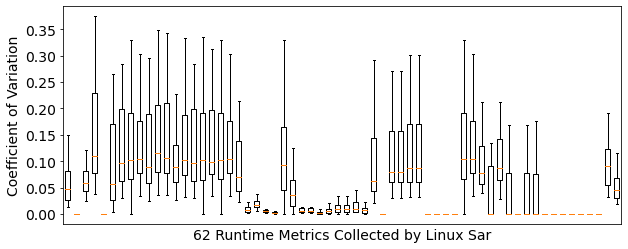

In [175]:
std_data = [[] for _ in range(np.shape(stat_res[0][0])[0])]
for res in stat_res:
    for i in range(len(res[0])):
        std_data[i].append(res[0][i])
plt.figure(figsize=(10, 4))
# plt.violinplot(std_data, showmedians=True)
plt.boxplot(std_data, showfliers=False)
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], fontsize=fontsize)
plt.xlabel('62 Runtime Metrics Collected by Linux Sar', fontsize=fontsize)
plt.xticks([])
plt.ylabel('Coefficient of Variation', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig('figures/raw_feat_cv.pdf')

In [161]:
print(sorted(std_data[0]))

[0.012335729367759125, 0.017115317260658156, 0.01739036592430937, 0.01826963148010227, 0.022214573534250652, 0.024449842598368514, 0.0251524209513643, 0.02549770598581085, 0.026028717999630937, 0.02910938566466268, 0.03138373322431114, 0.03308445017965704, 0.04118601953858823, 0.04560200084993496, 0.04638494465373189, 0.046518006206731966, 0.048850029940384045, 0.05478426379858974, 0.06038465962911368, 0.06290839090270203, 0.06487325429466662, 0.07219840423879867, 0.08418632565424827, 0.09416087815304157, 0.09460806933259654, 0.09495016691274938, 0.10893187195993852, 0.11232994552685513, 0.14648606182590437, 0.1489248161288519]


In [162]:
np.shape(std_data)

(62, 30)

In [163]:
medians = np.median(std_data, axis=1)

In [164]:
from sklearn.cluster import KMeans

In [165]:
kmeans = KMeans(n_clusters=2, random_state=0).fit([[x, 0] for x in medians])

In [166]:
kmeans.labels_

array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int32)

In [167]:
kmeans.cluster_centers_

array([[0.09130833, 0.        ],
       [0.00620911, 0.        ]])

In [168]:
valid_idxes = np.where(kmeans.labels_ == 0)[0]

In [169]:
summation = np.abs(summation)

In [170]:
valid_s = summation[valid_idxes]

In [171]:
t = []
for i in range(len(valid_s)):
    t.append(valid_s[i][valid_idxes])

In [172]:
t = np.asarray(t)

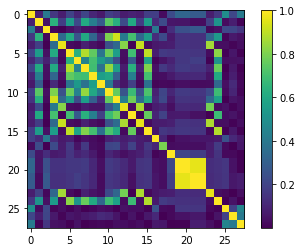

In [174]:
ax = plt.subplot(1, 1, 1)
im = ax.imshow(t)
plt.colorbar(im)
# plt.show()
# plt.clf()
plt.savefig('figures/raw_feat_cov.pdf')

In [182]:
art_valid_idxes = conf.get('dataset', 'non_zero_idx')
print(len(art_valid_idxes))
print(art_valid_idxes)

29
[0, 2, 5, 6, 8, 9, 14, 16, 18, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 45, 46, 48, 61]


In [183]:
selected_idxes = select_features(metrics_data, cof_threshold=0.6)
print(len(selected_idxes))
print(selected_idxes)

[ 2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 24 34 36 37 38 39 44
 45 46 48 60]
13
[2, 3, 5, 7, 8, 12, 19, 24, 34, 36, 46, 48, 60]


/data/home/liy/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/data/home/liy/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


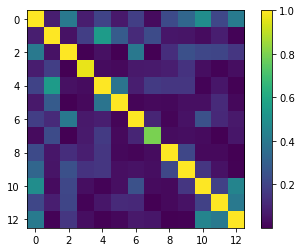

In [188]:
valid_s = summation[selected_idxes]
t1 = []
for i in range(len(valid_s)):
    t1.append(valid_s[i][selected_idxes])
ax = plt.subplot(1, 1, 1)
im = ax.imshow(t1)
plt.colorbar(im)
plt.show()
# plt.clf()
# plt.savefig('figures/sel_feat_cov.pdf')

In [22]:
set(selected_idxes) - set(art_valid_idxes)

{3, 7, 12, 19, 24, 47, 60}

In [27]:
tmp_data = data['1']['hadoop_pagerank']['large'][0].metrics

In [28]:
np.shape(tmp_data)

(96, 62)

In [31]:
tmp_max = np.max(tmp_data, axis=0)

In [32]:
max_vals = np.zeros(62)

In [180]:
hu_data_lg = data['1']['hive_union']['large'][0].raw_metrics[:,0]
hu_data_sl = data['1']['hive_union']['small'][0].raw_metrics[:,0]

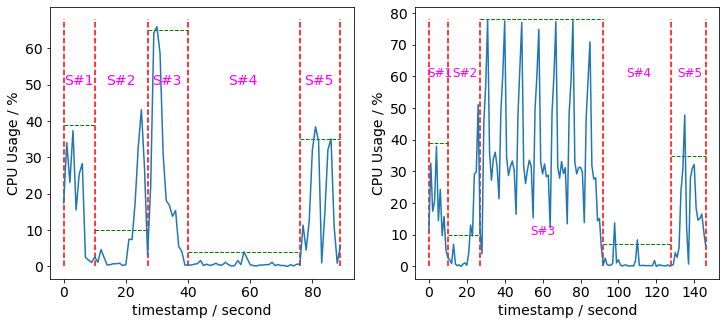

In [266]:
sp_1 = [(0, 'black'), (10, 'red'), (27, 'magenta'), (40, 'green'), (76, 'blue'), (len(hu_data_sl) - 1, 'black')]
sp_2 = [(0, 'black'), (10, 'red'), (27, 'magenta'), (92, 'green'), (128, 'blue'), (len(hu_data_lg) - 1, 'black')]

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
ax1.plot(hu_data_sl)
ax1.set_ylabel('CPU Usage / %', fontsize=fontsize)
ax1.set_yticks([0, 10, 20, 30, 40, 50, 60])
ax1.set_yticklabels([0, 10, 20, 30, 40, 50, 60], fontsize=fontsize)
ax1.set_xticks([0, 20, 40, 60, 80])
ax1.set_xticklabels([0, 20, 40, 60, 80], fontsize=fontsize)
ax1.set_xlabel('timestamp / second', fontsize=fontsize)
for sp in sp_1:
    ax1.vlines(sp[0], 0, 68, linestyles='--', linewidth=1.5, color='red')
for i in range(len(sp_1[:-1])):
    ax1.text((sp_1[i][0] + sp_1[i + 1][0]) / 2 - 5, 50, 'S#%d' % (i + 1), fontsize=fontsize, color='magenta')
ax1.hlines(39, 0, 10, linestyles='--', linewidth=1.0, color='green')
ax1.hlines(10, 10, 27, linestyles='--', linewidth=1.0, color='green')
ax1.hlines(65, 27, 40, linestyles='--', linewidth=1.0, color='green')
ax1.hlines(4, 40, 76, linestyles='--', linewidth=1.0, color='green')
ax1.hlines(35, 76, len(hu_data_sl) - 1, linestyles='--', linewidth=1.0, color='green')

ax2.plot(hu_data_lg)
ax2.set_ylabel('CPU Usage / %', fontsize=fontsize)
ax2.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
ax2.set_yticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80], fontsize=fontsize)
ax2.set_xticks([0, 20, 40, 60, 80, 100, 120, 140])
ax2.set_xticklabels([0, 20, 40, 60, 80, 100, 120, 140], fontsize=fontsize)
ax2.set_xlabel('timestamp / second', fontsize=fontsize)
for sp in sp_2:
    ax2.vlines(sp[0], 0, 78, linestyles='--', linewidth=1.5, color='red')
ys = [60, 60, 10, 60, 60]
for i in range(len(sp_2[:-1])):
    ax2.text((sp_2[i][0] + sp_2[i + 1][0]) / 2 - 6, ys[i], 'S#%d' % (i + 1), fontsize=fontsize-2, color='magenta')
ax2.hlines(39, 0, 10, linestyles='--', linewidth=1.0, color='green')
ax2.hlines(10, 10, 27, linestyles='--', linewidth=1.0, color='green')
ax2.hlines(78, 27, 92, linestyles='--', linewidth=1.0, color='green')
ax2.hlines(7, 92, 128, linestyles='--', linewidth=1.0, color='green')
ax2.hlines(35, 128, len(hu_data_lg) - 1, linestyles='--', linewidth=1.0, color='green')
#plt.show()
plt.savefig('figures/hu_cpu.pdf')
#plt.clf()
#plt.plot(hu_data_sl)
#plt.show()
#plt.clf()

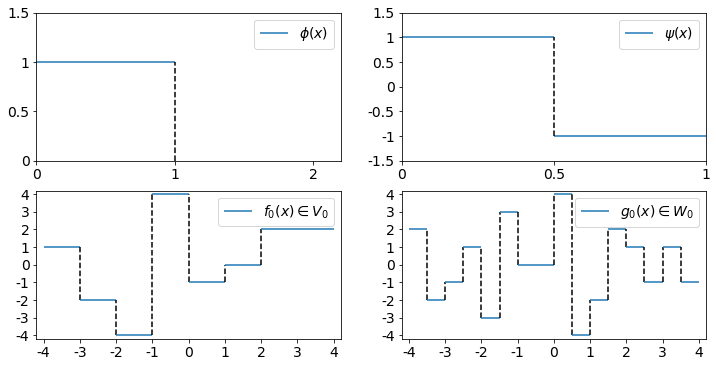

In [280]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.set_ylim(0, 1.5)
ax1.set_xlim(0, 2.2)
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels([0, 1, 2], fontsize=fontsize)
ax1.set_yticks([0, 0.5, 1, 1.5])
ax1.set_yticklabels([0, 0.5, 1, 1.5], fontsize=fontsize)
ax1.hlines(1, 0, 1, label=r'$\phi(x)$')
ax1.vlines(1, 0, 1, linestyles='--', linewidth=1.5, color='black')
ax1.legend(fontsize=fontsize)

ax2.set_ylim(-1.5, 1.5)
ax2.set_xlim(0, 1,2)
ax2.set_xticks([0, 0.5, 1])
ax2.set_xticklabels([0, 0.5, 1], fontsize=fontsize)
ax2.set_yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
ax2.set_yticklabels([-1.5, -1, -0.5, 0, 0.5, 1, 1.5], fontsize=fontsize)
ax2.hlines(1, 0, 0.5, label=r'$\psi(x)$')
ax2.hlines(-1, 0.5, 1)
ax2.vlines(0.5, -1, 1, linestyles='--', linewidth=1.5, color='black')
ax2.legend(fontsize=fontsize)

ax3.set_ylim(-4.2, 4.2)
ax3.set_xlim(-4.2, 4.2)
ax3.set_xticks(np.arange(-4, 5, 1))
ax3.set_xticklabels(np.arange(-4, 5, 1), fontsize=fontsize)
ax3.set_yticks(np.arange(-4, 5, 1))
ax3.set_yticklabels(np.arange(-4, 5, 1), fontsize=fontsize)
ax3.hlines(1, -4, -3, label=r'$f_0(x) \in V_0$')
ax3.vlines(-3, -2, 1, linestyles='--', linewidth=1.5, color='black')
ax3.hlines(-2, -3, -2)
ax3.vlines(-2, -4, -2, linestyles='--', linewidth=1.5, color='black')
ax3.hlines(-4, -2, -1)
ax3.vlines(-1, -4, 4, linestyles='--', linewidth=1.5, color='black')
ax3.hlines(4, -1, 0)
ax3.vlines(0, -1, 4, linestyles='--', linewidth=1.5, color='black')
ax3.hlines(-1, 0, 1)
ax3.vlines(1, -1, 0, linestyles='--', linewidth=1.5, color='black')
ax3.hlines(0, 1, 2)
ax3.vlines(2, 0, 2, linestyles='--', linewidth=1.5, color='black')
ax3.hlines(2, 2, 4)
ax3.legend(fontsize=fontsize)

ax4.set_ylim(-4.2, 4.2)
ax4.set_xlim(-4.2, 4.2)
ax4.set_xticks(np.arange(-4, 5, 1))
ax4.set_xticklabels(np.arange(-4, 5, 1), fontsize=fontsize)
ax4.set_yticks(np.arange(-4, 5, 1))
ax4.set_yticklabels(np.arange(-4, 5, 1), fontsize=fontsize)
ax4.hlines(2, -4, -3.5, label=r'$g_0(x) \in W_0$')
ax4.vlines(-3.5, -2, 2, linestyles='--', linewidth=1.5, color='black')
ax4.hlines(-2, -3.5, -3)
ax4.vlines(-3, -2, -1, linestyles='--', linewidth=1.5, color='black')
ax4.hlines(-1, -3, -2.5)
ax4.vlines(-2.5, -1, 1, linestyles='--', linewidth=1.5, color='black')
ax4.hlines(1, -2.5, -2)
ax4.vlines(-2, -3, 1, linestyles='--', linewidth=1.5, color='black')
ax4.hlines(-3, -2, -1.5)
ax4.vlines(-1.5, -3, 3, linestyles='--', linewidth=1.5, color='black')
ax4.hlines(3, -1.5, -1)
ax4.vlines(-1, 0, 3, linestyles='--', linewidth=1.5, color='black')
ax4.hlines(0, -1, 0)
ax4.vlines(0, 0, 4, linestyles='--', linewidth=1.5, color='black')
ax4.hlines(4, 0, 0.5)
ax4.vlines(0.5, -4, 4, linestyles='--', linewidth=1.5, color='black')
ax4.hlines(-4, 0.5, 1)
ax4.vlines(1, -4, -2, linestyles='--', linewidth=1.5, color='black')
ax4.hlines(-2, 1, 1.5)
ax4.vlines(1.5, -2, 2, linestyles='--', linewidth=1.5, color='black')
ax4.hlines(2, 1.5, 2)
ax4.vlines(2, 1, 2, linestyles='--', linewidth=1.5, color='black')
ax4.hlines(1, 2, 2.5)
ax4.vlines(2.5, -1, 1, linestyles='--', linewidth=1.5, color='black')
ax4.hlines(-1, 2.5, 3)
ax4.vlines(3, -1, 1, linestyles='--', linewidth=1.5, color='black')
ax4.hlines(1, 3, 3.5)
ax4.vlines(3.5, -1, 1, linestyles='--', linewidth=1.5, color='black')
ax4.hlines(-1, 3.5, 4)
ax4.legend(fontsize=fontsize)

#fig.legend()
plt.show()
#plt.savefig('figures/phi_psi_eg.pdf')

In [282]:
with open('repro.json', 'r') as fd:
    baseline_data = json.load(fd)

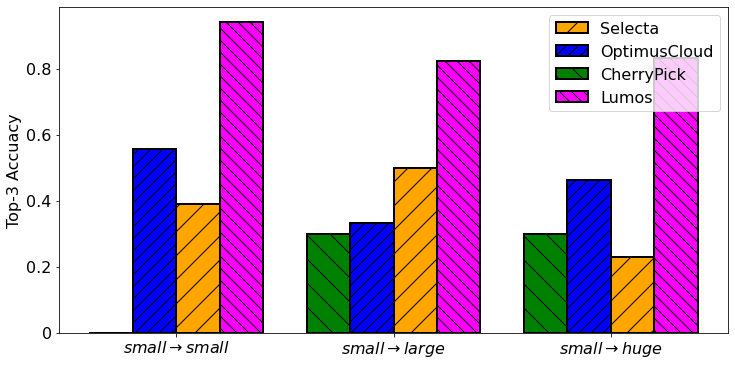

[0.389, 0.5, 0.231]
[0.556, 0.333, 0.462]
[0, 0.3, 0.3]
[0.9411764705882353, 0.8235294117647058, 0.8333333333333334]


In [358]:
fontsize=16
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

selecta_data = [v['top3']['jct'] for k, v in baseline_data['1']['selecta'].items()]
opcloud_data = [v['top3']['jct'] for k, v in baseline_data['1']['optimuscloud'].items()]
chepick_data = [0]
chepick_data.extend([v['top3']['jct'] for k, v in baseline_data['1']['cherrypick'].items()])
lumos_data = [16/17, 14/17, 10/12]

width = 0.2
chepick_xticks = [x - 1.5 * width for x in range(len(selecta_data))]
opcloud_xticks = [x - 0.5 * width for x in range(len(opcloud_data))]
selecta_xticks = [x + 0.5 * width for x in range(len(chepick_data))]
lumos_xticks = [x + 1.5 * width for x in range(len(lumos_data))]

ax.bar(selecta_xticks, selecta_data, label='Selecta', color='orange', edgecolor='black', hatch='/', width=width, lw=2)
ax.bar(opcloud_xticks, opcloud_data, label='OptimusCloud', color='blue', edgecolor='black', hatch='//', width=width, lw=2)
ax.bar(chepick_xticks, chepick_data, label='CherryPick', color='green', edgecolor='black', hatch='\\', width=width, lw=2)
ax.bar(lumos_xticks, lumos_data, label='Lumos', color='magenta', edgecolor='black', hatch='\\\\', width=width, lw=2)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels([r'$small \rightarrow small$', r'$small \rightarrow large$', r'$small \rightarrow huge$'], fontsize=fontsize)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8], fontsize=fontsize)
ax.set_ylabel('Top-3 Accuacy', fontsize=fontsize)
ax.legend(fontsize=fontsize)

plt.show()
#plt.savefig('figures/expr1-top-3.pdf')

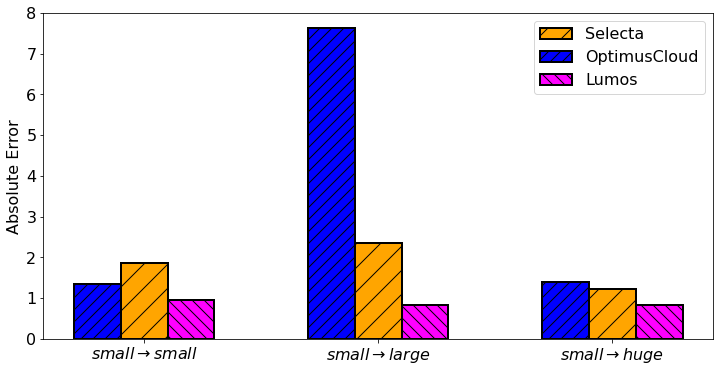

In [330]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

selecta_data = [0, 0, 0]
cnt = 0
for k, v in baseline_data['1']['selecta']['small'].items():
    if 'top' in k: continue
    selecta_data[0] += v['jct_absolute']
    cnt += 1
selecta_data[0] /= cnt
cnt = 0
for k, v in baseline_data['1']['selecta']['large'].items():
    if 'top' in k: continue
    selecta_data[1] += v['jct_absolute']
    cnt += 1
selecta_data[1] /= cnt
for k, v in baseline_data['1']['selecta']['huge'].items():
    if 'top' in k: continue
    selecta_data[2] += v['jct_absolute']
    cnt += 1
selecta_data[2] /= cnt

opcloud_data = [0, 0, 0]
cnt = 0
for k, v in baseline_data['1']['optimuscloud']['small'].items():
    if 'top' in k: continue
    opcloud_data[0] += v['jct_absolute']
    cnt += 1
opcloud_data[0] /= cnt
cnt = 0
for k, v in baseline_data['1']['optimuscloud']['large'].items():
    if 'top' in k: continue
    opcloud_data[1] += v['jct_absolute']
    cnt += 1
opcloud_data[1] /= cnt
for k, v in baseline_data['1']['optimuscloud']['huge'].items():
    if 'top' in k: continue
    opcloud_data[2] += v['jct_absolute']
    cnt += 1
opcloud_data[2] /= cnt

lumos_data = [16/17, 14/17, 10/12]

width = 0.2
opcloud_xticks = [x - width for x in range(len(opcloud_data))]
selecta_xticks = [x for x in range(len(chepick_data))]
lumos_xticks = [x + width for x in range(len(lumos_data))]

ax.bar(selecta_xticks, selecta_data, label='Selecta', color='orange', edgecolor='black', hatch='/', width=width, lw=2)
ax.bar(opcloud_xticks, opcloud_data, label='OptimusCloud', color='blue', edgecolor='black', hatch='//', width=width, lw=2)
ax.bar(lumos_xticks, lumos_data, label='Lumos', color='magenta', edgecolor='black', hatch='\\\\', width=width, lw=2)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels([r'$small \rightarrow small$', r'$small \rightarrow large$', r'$small \rightarrow huge$'], fontsize=fontsize)
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax.set_yticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8], fontsize=fontsize)
ax.set_ylabel('Absolute Error', fontsize=fontsize)
ax.legend(fontsize=fontsize)

#plt.show()
plt.savefig('figures/expr1-abs-err.pdf')

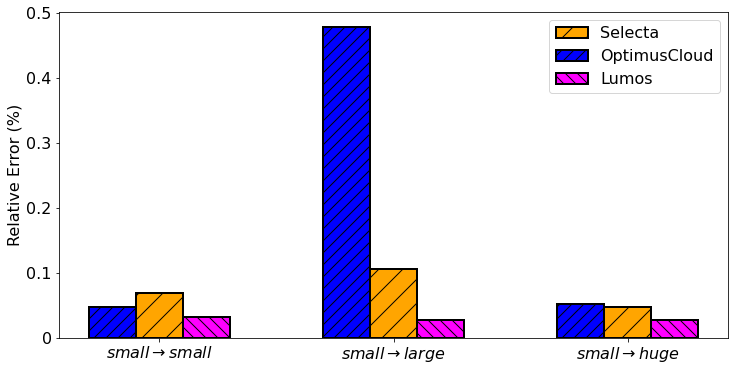

In [336]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

selecta_data = [0, 0, 0]
cnt = 0
for k, v in baseline_data['1']['selecta']['small'].items():
    if 'top' in k: continue
    selecta_data[0] += v['jct_relative']
    cnt += 1
selecta_data[0] /= cnt
cnt = 0
for k, v in baseline_data['1']['selecta']['large'].items():
    if 'top' in k: continue
    selecta_data[1] += v['jct_relative']
    cnt += 1
selecta_data[1] /= cnt
for k, v in baseline_data['1']['selecta']['huge'].items():
    if 'top' in k: continue
    selecta_data[2] += v['jct_relative']
    cnt += 1
selecta_data[2] /= cnt

opcloud_data = [0, 0, 0]
cnt = 0
for k, v in baseline_data['1']['optimuscloud']['small'].items():
    if 'top' in k: continue
    opcloud_data[0] += v['jct_relative']
    cnt += 1
opcloud_data[0] /= cnt
cnt = 0
for k, v in baseline_data['1']['optimuscloud']['large'].items():
    if 'top' in k: continue
    opcloud_data[1] += v['jct_relative']
    cnt += 1
opcloud_data[1] /= cnt
for k, v in baseline_data['1']['optimuscloud']['huge'].items():
    if 'top' in k: continue
    opcloud_data[2] += v['jct_relative']
    cnt += 1
opcloud_data[2] /= cnt

lumos_data = [16/17/30, 14/17/30, 10/12/30]

width = 0.2
opcloud_xticks = [x - width for x in range(len(opcloud_data))]
selecta_xticks = [x for x in range(len(chepick_data))]
lumos_xticks = [x + width for x in range(len(lumos_data))]

ax.bar(selecta_xticks, selecta_data, label='Selecta', color='orange', edgecolor='black', hatch='/', width=width, lw=2)
ax.bar(opcloud_xticks, opcloud_data, label='OptimusCloud', color='blue', edgecolor='black', hatch='//', width=width, lw=2)
ax.bar(lumos_xticks, lumos_data, label='Lumos', color='magenta', edgecolor='black', hatch='\\\\', width=width, lw=2)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels([r'$small \rightarrow small$', r'$small \rightarrow large$', r'$small \rightarrow huge$'], fontsize=fontsize)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=fontsize)
ax.set_ylabel('Relative Error (%)', fontsize=fontsize)
ax.legend(fontsize=fontsize)

#plt.show()
plt.savefig('figures/expr1-rel-err.pdf')

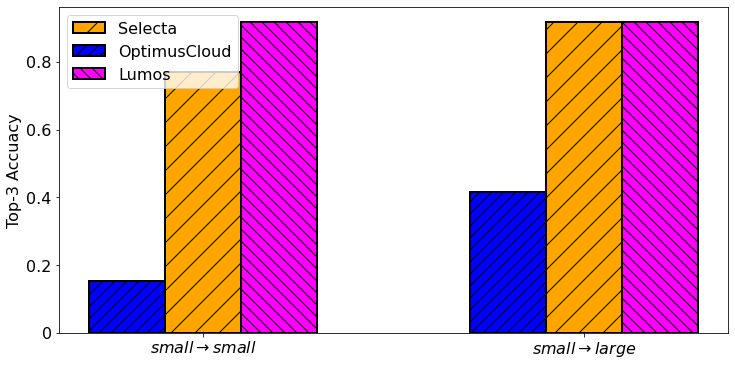

In [343]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

selecta_data = [v['top3']['jct'] for k, v in baseline_data['3']['selecta'].items()]
opcloud_data = [v['top3']['jct'] for k, v in baseline_data['3']['optimuscloud'].items()]
lumos_data = [11/12, 11/12]

width = 0.2
opcloud_xticks = [x - width for x in range(len(opcloud_data))]
selecta_xticks = [x for x in range(len(selecta_data))]
lumos_xticks = [x + width for x in range(len(lumos_data))]

ax.bar(selecta_xticks, selecta_data, label='Selecta', color='orange', edgecolor='black', hatch='/', width=width, lw=2)
ax.bar(opcloud_xticks, opcloud_data, label='OptimusCloud', color='blue', edgecolor='black', hatch='//', width=width, lw=2)
ax.bar(lumos_xticks, lumos_data, label='Lumos', color='magenta', edgecolor='black', hatch='\\\\', width=width, lw=2)

ax.set_xticks([0, 1])
ax.set_xticklabels([r'$small \rightarrow small$', r'$small \rightarrow large$'], fontsize=fontsize)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8], fontsize=fontsize)
ax.set_ylabel('Top-3 Accuacy', fontsize=fontsize)
ax.legend(fontsize=fontsize)

#plt.show()
plt.savefig('figures/expr2-top-3.pdf')

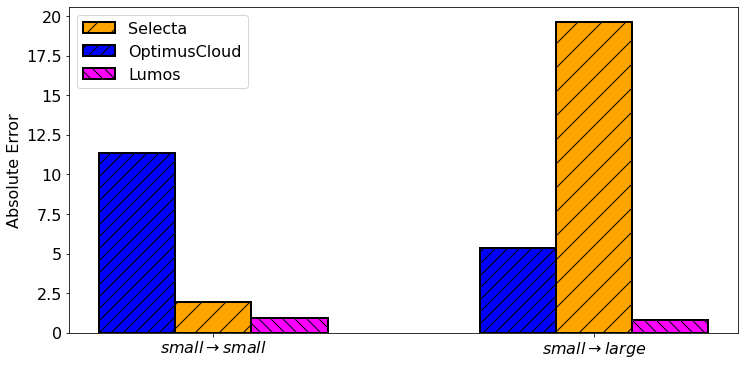

0.8235294117647058 19.613
0.9580110430956658


In [383]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

selecta_data = [0, 0]
cnt = 0
for k, v in baseline_data['3']['selecta']['small'].items():
    if 'top' in k: continue
    selecta_data[0] += v['jct_absolute']
    cnt += 1
selecta_data[0] /= cnt
cnt = 0
for k, v in baseline_data['3']['selecta']['large'].items():
    if 'top' in k: continue
    selecta_data[1] += v['jct_absolute']
    cnt += 1

opcloud_data = [0, 0]
cnt = 0
for k, v in baseline_data['3']['optimuscloud']['small'].items():
    if 'top' in k: continue
    opcloud_data[0] += v['jct_absolute']
    cnt += 1
opcloud_data[0] /= cnt
cnt = 0
for k, v in baseline_data['3']['optimuscloud']['large'].items():
    if 'top' in k: continue
    opcloud_data[1] += v['jct_absolute']
    cnt += 1
opcloud_data[1] /= cnt

lumos_data = [16/17, 14/17]

width = 0.2
opcloud_xticks = [x - width for x in range(len(opcloud_data))]
selecta_xticks = [x for x in range(len(selecta_data))]
lumos_xticks = [x + width for x in range(len(lumos_data))]

ax.bar(selecta_xticks, selecta_data, label='Selecta', color='orange', edgecolor='black', hatch='/', width=width, lw=2)
ax.bar(opcloud_xticks, opcloud_data, label='OptimusCloud', color='blue', edgecolor='black', hatch='//', width=width, lw=2)
ax.bar(lumos_xticks, lumos_data, label='Lumos', color='magenta', edgecolor='black', hatch='\\\\', width=width, lw=2)

ax.set_xticks([0, 1])
ax.set_xticklabels([r'$small \rightarrow small$', r'$small \rightarrow large$'], fontsize=fontsize)
ax.set_yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20])
ax.set_yticklabels([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20], fontsize=fontsize)
ax.set_ylabel('Absolute Error', fontsize=fontsize)
ax.legend(fontsize=fontsize)

plt.show()
#plt.savefig('figures/expr2-abs-err.pdf')
print(lumos_data[1], selecta_data[1])
print((selecta_data[1] - lumos_data[1]) / selecta_data[1])

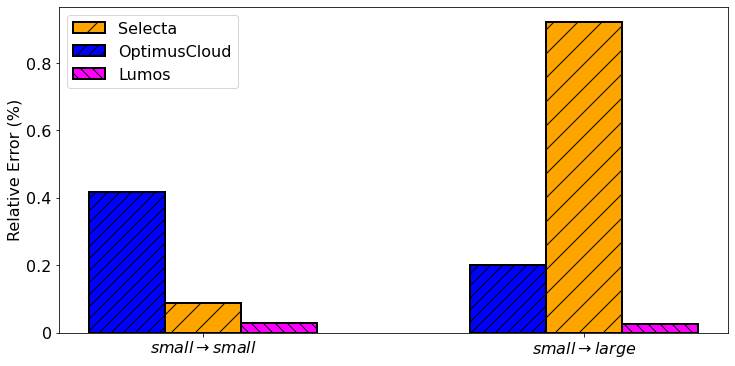

In [356]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

selecta_data = [0, 0]
cnt = 0
for k, v in baseline_data['3']['selecta']['small'].items():
    if 'top' in k: continue
    selecta_data[0] += v['jct_relative']
    cnt += 1
selecta_data[0] /= cnt
cnt = 0
for k, v in baseline_data['3']['selecta']['large'].items():
    if 'top' in k: continue
    selecta_data[1] += v['jct_relative']
    cnt += 1

opcloud_data = [0, 0]
cnt = 0
for k, v in baseline_data['3']['optimuscloud']['small'].items():
    if 'top' in k: continue
    opcloud_data[0] += v['jct_relative']
    cnt += 1
opcloud_data[0] /= cnt
cnt = 0
for k, v in baseline_data['3']['optimuscloud']['large'].items():
    if 'top' in k: continue
    opcloud_data[1] += v['jct_relative']
    cnt += 1
opcloud_data[1] /= cnt

lumos_data = [16/17/31, 14/17/31]

width = 0.2
opcloud_xticks = [x - width for x in range(len(opcloud_data))]
selecta_xticks = [x for x in range(len(selecta_data))]
lumos_xticks = [x + width for x in range(len(lumos_data))]

ax.bar(selecta_xticks, selecta_data, label='Selecta', color='orange', edgecolor='black', hatch='/', width=width, lw=2)
ax.bar(opcloud_xticks, opcloud_data, label='OptimusCloud', color='blue', edgecolor='black', hatch='//', width=width, lw=2)
ax.bar(lumos_xticks, lumos_data, label='Lumos', color='magenta', edgecolor='black', hatch='\\\\', width=width, lw=2)

ax.set_xticks([0, 1])
ax.set_xticklabels([r'$small \rightarrow small$', r'$small \rightarrow large$'], fontsize=fontsize)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8], fontsize=fontsize)
ax.set_ylabel('Relative Error (%)', fontsize=fontsize)
ax.legend(fontsize=fontsize)

#plt.show()
plt.savefig('figures/expr2-rel-err.pdf')

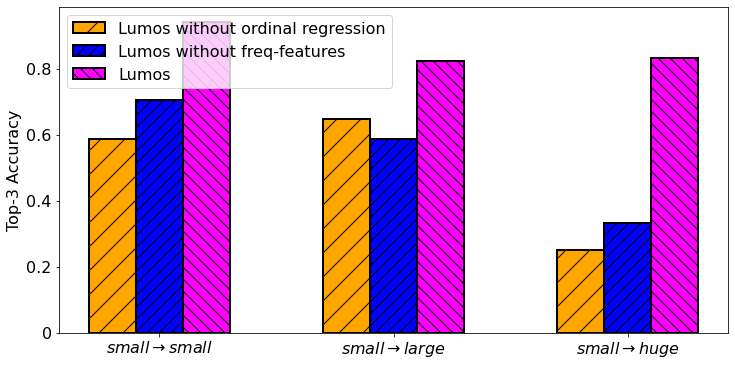

In [370]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

lumos_1_data = [10/17, 11/17, 3/12]
lumos_2_data = [12/17, 10/17, 4/12]
lumos_data = [16/17, 14/17, 10/12]

width = 0.2
lumos_1_xticks = [x - width for x in range(len(lumos_1_data))]
lumos_2_xticks = [x for x in range(len(lumos_2_data))]
lumos_xticks = [x + width for x in range(len(lumos_data))]

ax.bar(lumos_1_xticks, lumos_1_data, label='Lumos without ordinal regression', color='orange', edgecolor='black', hatch='/', width=width, lw=2)
ax.bar(lumos_2_xticks, lumos_2_data, label='Lumos without freq-features', color='blue', edgecolor='black', hatch='//', width=width, lw=2)
ax.bar(lumos_xticks, lumos_data, label='Lumos', color='magenta', edgecolor='black', hatch='\\\\', width=width, lw=2)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels([r'$small \rightarrow small$', r'$small \rightarrow large$', r'$small \rightarrow huge$'], fontsize=fontsize)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8], fontsize=fontsize)
ax.set_ylabel('Top-3 Accuracy', fontsize=fontsize)
ax.legend(fontsize=fontsize)

#plt.show()
plt.savefig('figures/expr3-top-3.pdf')

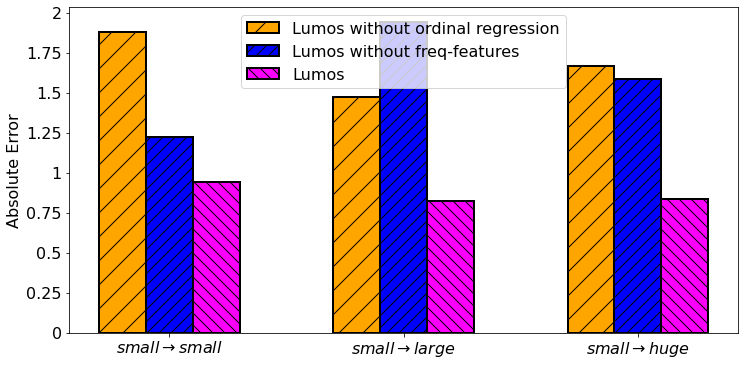

In [371]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

lumos_1_data = [32/17, 25/17, 20/12]
lumos_2_data = [33/27, 33/17, 19/12]
lumos_data = [16/17, 14/17, 10/12]

width = 0.2
lumos_1_xticks = [x - width for x in range(len(lumos_1_data))]
lumos_2_xticks = [x for x in range(len(lumos_2_data))]
lumos_xticks = [x + width for x in range(len(lumos_data))]

ax.bar(lumos_1_xticks, lumos_1_data, label='Lumos without ordinal regression', color='orange', edgecolor='black', hatch='/', width=width, lw=2)
ax.bar(lumos_2_xticks, lumos_2_data, label='Lumos without freq-features', color='blue', edgecolor='black', hatch='//', width=width, lw=2)
ax.bar(lumos_xticks, lumos_data, label='Lumos', color='magenta', edgecolor='black', hatch='\\\\', width=width, lw=2)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels([r'$small \rightarrow small$', r'$small \rightarrow large$', r'$small \rightarrow huge$'], fontsize=fontsize)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2])
ax.set_yticklabels([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2], fontsize=fontsize)
ax.set_ylabel('Absolute Error', fontsize=fontsize)
ax.legend(fontsize=fontsize)

#plt.show()
plt.savefig('figures/expr3-abs-err.pdf')

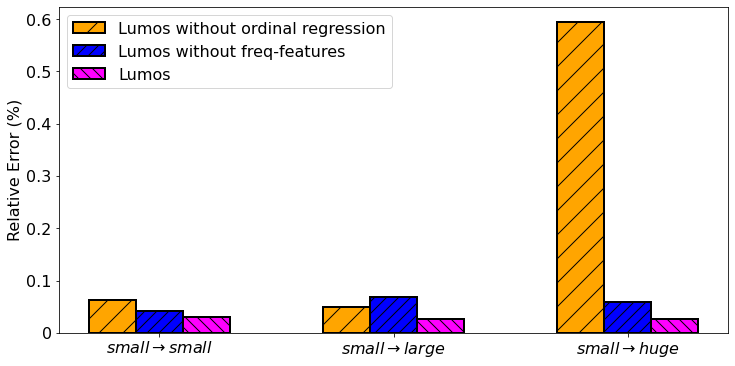

In [375]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

lumos_1_data = [33/17/31, 26/17/31, 221/12/31]
lumos_2_data = [35/27/31, 36/17/31, 22/12/31]
lumos_data = [16/17/31, 14/17/31, 10/12/31]

width = 0.2
lumos_1_xticks = [x - width for x in range(len(lumos_1_data))]
lumos_2_xticks = [x for x in range(len(lumos_2_data))]
lumos_xticks = [x + width for x in range(len(lumos_data))]

ax.bar(lumos_1_xticks, lumos_1_data, label='Lumos without ordinal regression', color='orange', edgecolor='black', hatch='/', width=width, lw=2)
ax.bar(lumos_2_xticks, lumos_2_data, label='Lumos without freq-features', color='blue', edgecolor='black', hatch='//', width=width, lw=2)
ax.bar(lumos_xticks, lumos_data, label='Lumos', color='magenta', edgecolor='black', hatch='\\\\', width=width, lw=2)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels([r'$small \rightarrow small$', r'$small \rightarrow large$', r'$small \rightarrow huge$'], fontsize=fontsize)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=fontsize)
ax.set_ylabel('Relative Error (%)', fontsize=fontsize)
ax.legend(fontsize=fontsize)

#plt.show()
plt.savefig('figures/expr3-rel-err.pdf')